In [1]:
import os, sys, io, csv
import numpy as np
import pandas as pd  
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.font_manager as mfm

import nglview as nv
import MDAnalysis as mda
from MDAnalysis import Universe, Merge, transformations

res_png=600
plt.style.use(['ieee','notebook','no-latex'])
class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

A Jupyter Widget

In [2]:
print(np.__version__)

1.23.4


In [3]:
print(pd.__version__)

1.5.2


In [4]:
print(sp.__version__)

1.11.1


In [5]:
print(nv.__version__)

3.0.3


In [6]:
print(mda.__version__)

2.7.0


In [7]:
import matplotlib
print(matplotlib.__version__)

3.6.2


In [8]:
assetsDir="./nb_assets/"

# 1. Performance of UANanoDock (Fig.4 in text)

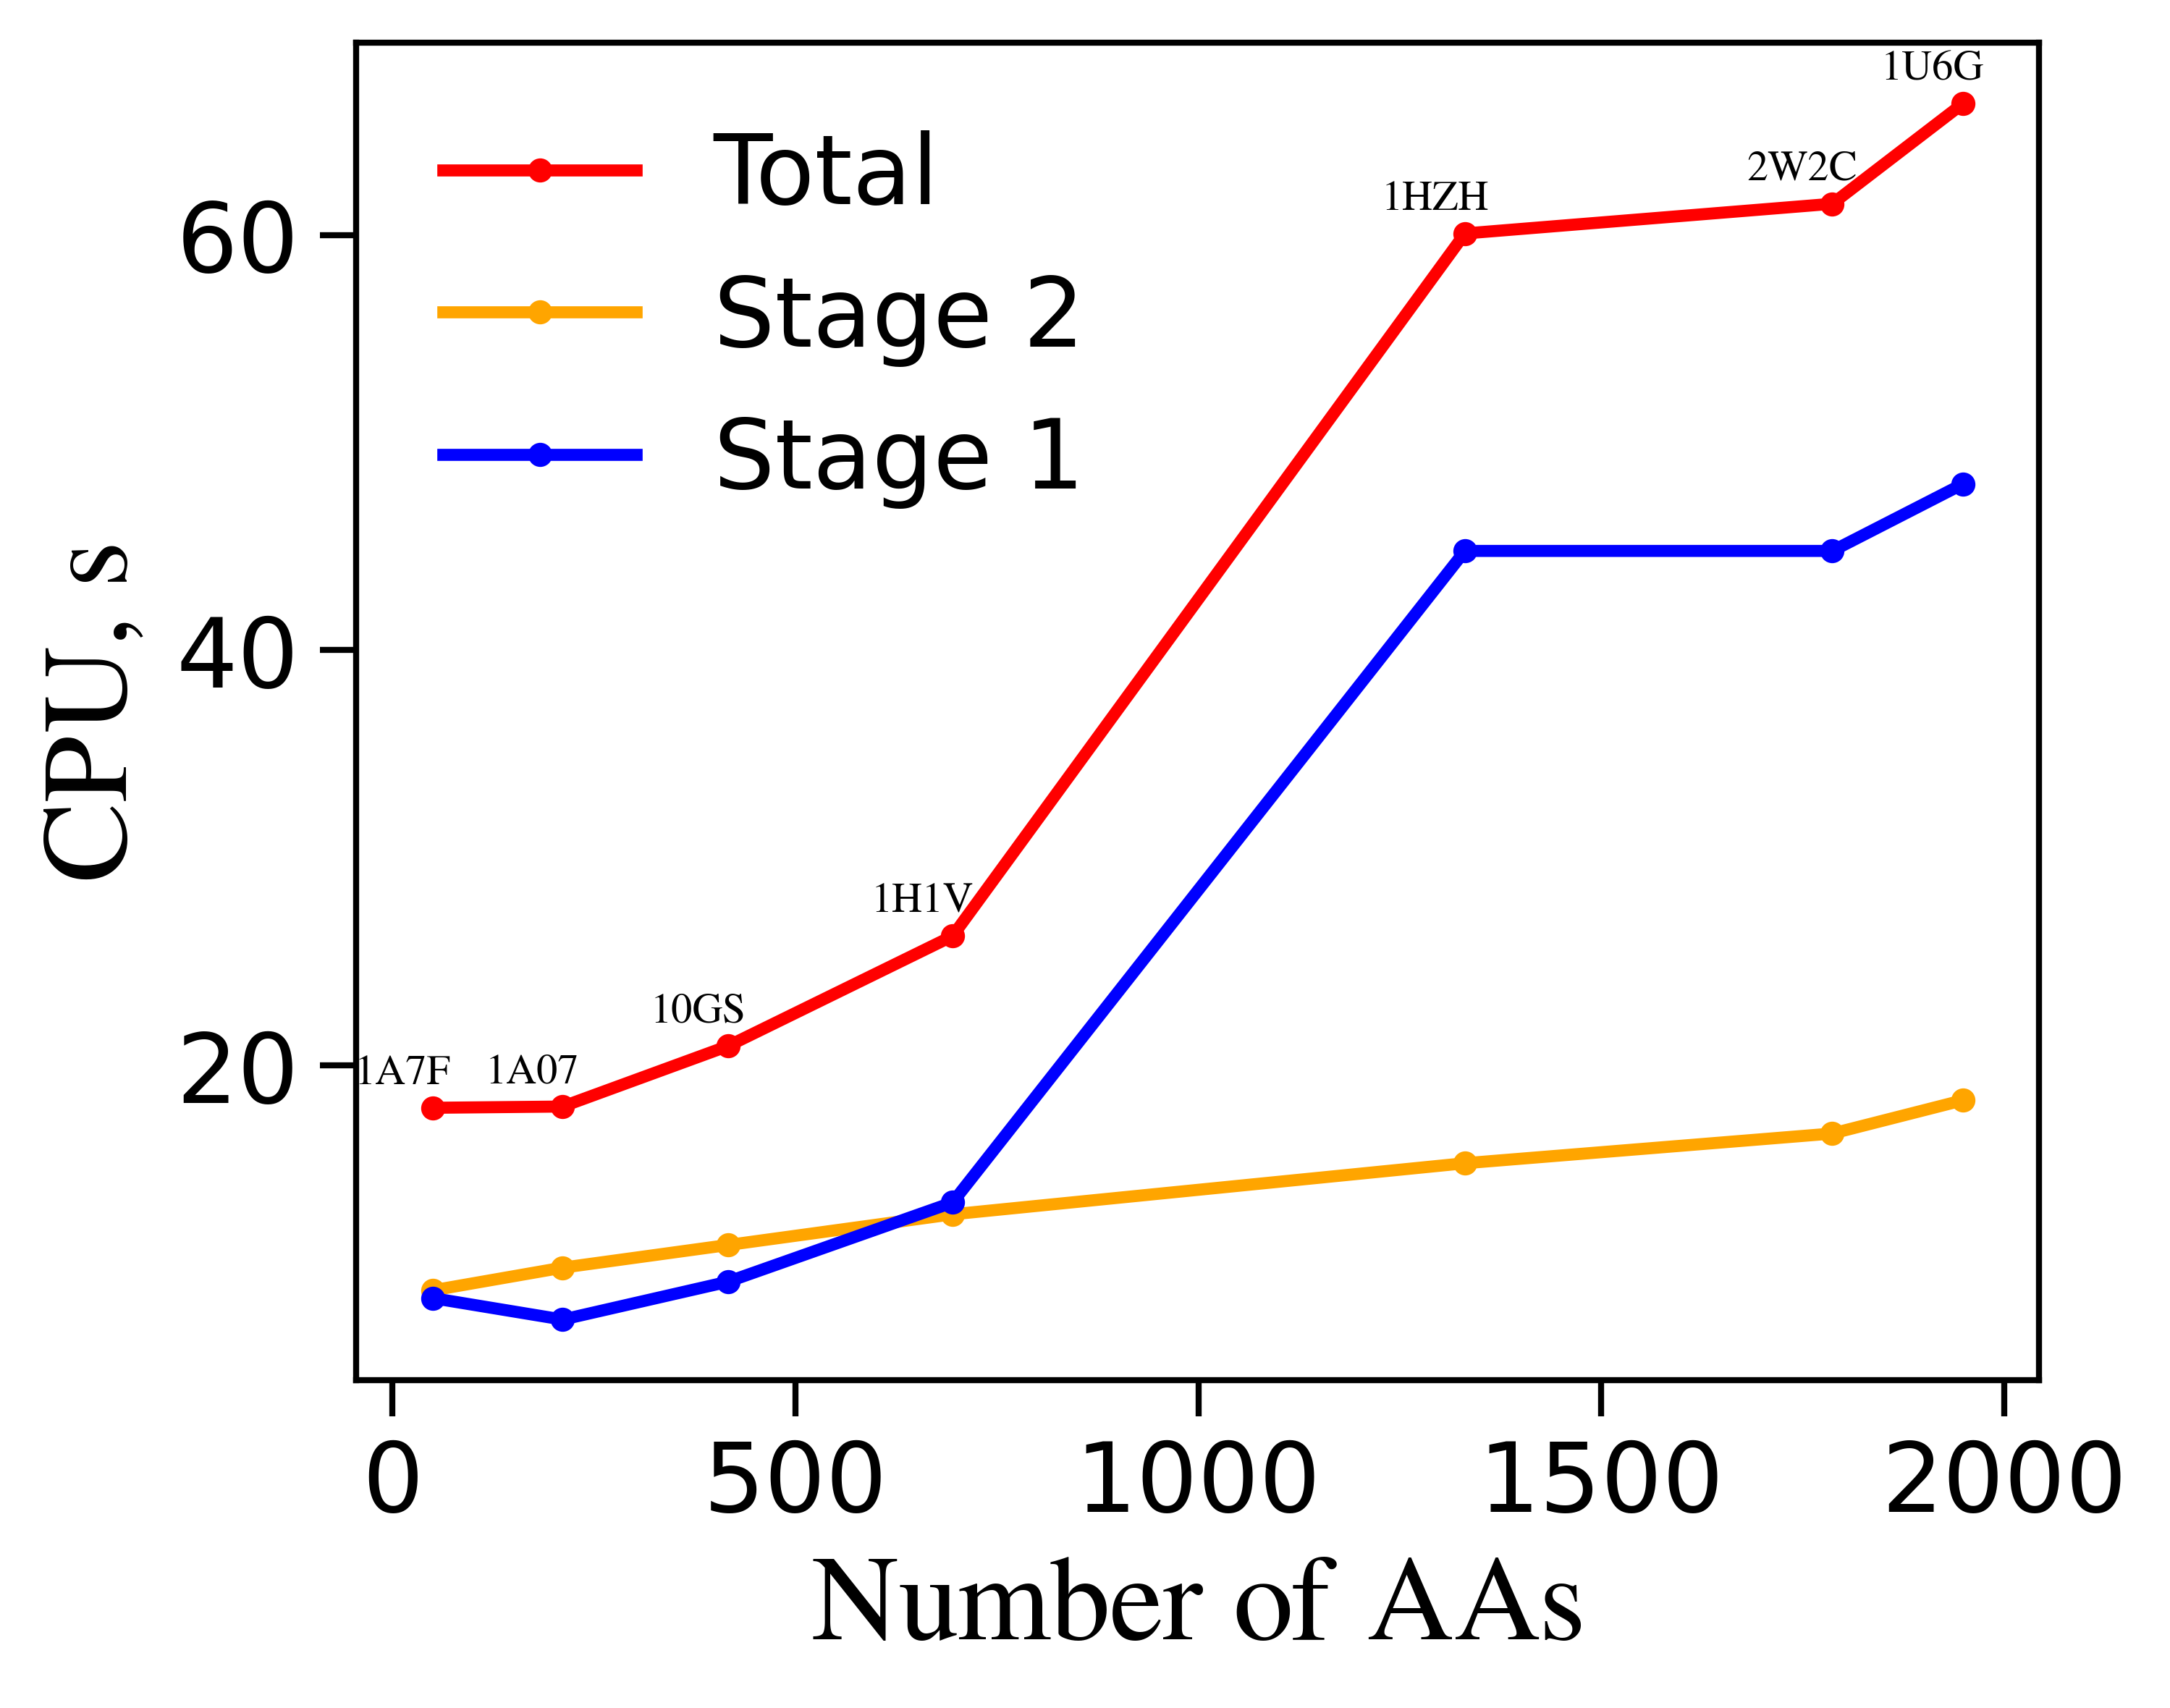

In [9]:
bench = pd.read_csv('benchmarking.csv')

font_path = "/usr/share/fonts/truetype/freefont/FreeSerif.ttf"
fontsize  = 20
clabelpad = 20

font      = mfm.FontProperties(fname = font_path, size = fontsize)
tickFont      = mfm.FontProperties(fname = font_path, size = 14, weight="bold")
thickFont      = mfm.FontProperties(fname = font_path, size = 7, weight="black")

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

ax.set_prop_cycle(color=['red','orange','blue'])
plt.plot(bench.n_aa, bench.cpu_total,  linewidth=2, label="Total", marker ='.')
for i, _ in enumerate(bench.cpu_total):
    plt.annotate(bench.prot[i].upper(), (bench.n_aa[i], bench.cpu_total[i]),
                 textcoords="offset points", xytext=(-5,4), ha='center', fontproperties = thickFont)

plt.plot(bench.n_aa, bench.cpu_ua,   linewidth=2, label="Stage 2", marker ='.')
plt.plot(bench.n_aa, bench.cpu_propka,   linewidth=2, label="Stage 1", marker ='.')

ax.set_xlabel("Number of AAs", fontproperties = font)
ax.set_ylabel("CPU, s", fontproperties = font)
ax.tick_params(tick1On=True)
plt.legend(loc="upper left", frameon=False)
plt.savefig(assetsDir+'benchmarking.png', format='png', dpi=res_png,  transparent=True, bbox_inches='tight')

![benchmarking.png](nb_assets/benchmarking.png)

# 2. Read-in data for in-silico immunoassay design (IgG-AgNP case study)

In [14]:
pH = [6.8, 7.3,8.5]
Temp=309.75
fcc=111
R = [2, 4 , 8, 10 , 15, 20, 25, 30,35 ,40,45, 50 ]
zPot = [0.0*10**(-3),-10.0*10**(-3) , -20.0*10**(-3) ,-30.0*10**(-3) , -40.0*10**(-3) ,-50.0*10**(-3) ,-60.0*10**(-3)]
#pdbID="1hzh"

In [15]:
#wd=os.getcwd()+"/scaleup/res/"
wd="./scaleup/res/"
folderList=[k for k in (next(os.walk(wd))[1]) if ".ipynb_checkpoints" not in k]
folderList

['7.3', '8.5', '6.8']

In [10]:
#note conversion of SD from kBt to kJ/mol
def get_lowest(uam_to_check=""):
    rawData         = np.genfromtxt(uam_to_check)[:,0:7]
    phiData         = rawData[:,0]
    thetaData       = rawData[:,1]
    energy          = rawData[:,6] #kJ/mol
    SD              = 2.49* rawData[:,3] #kBt=>kJ/mol
    sinTheta        = np.sin((2.5+thetaData) * np.pi / 180.0)
    boltzmanAverage = np.sum(energy * sinTheta * np.exp(-1.0 *  energy)) / np.sum(sinTheta * np.exp(-1.0 * energy))
    simpleAverage   = np.sum(sinTheta * energy)/np.sum(sinTheta) # corrected so that it works properly for isotropic proteins and single AAs with E(phi,theta) = E, else we get Esimple =  2E/Pi 
    index           = np.argmin(energy)
    return energy[index], phiData[index],  thetaData[index], SD[index], boltzmanAverage

In [11]:
dic={'protName': '',
 'core': '',
 'fcc': '',
 'r': '',
 'zp': '',
 'eads': '', # absolute local minimum at the adsorbtion heatmap coresponds to single orientations
 'psi': '',
 'theta': '',
 'ph': '',
 'sd': '',
 'eave': ''} # averaged (Boltzmann) adsorbtion energy, incl. contributions from all orientations

In [12]:
col_names=list(dic.keys())
df = pd.DataFrame(columns=col_names)

In [16]:
resArr=[]
uamsArr=[]
prot="1hzh"
core="Ag"
fcc="111"
tagP="propKa2UA"# PDB file cleaned for UA by UANanoDock
for ph in folderList:
    searchFolder=wd+ph+"/"
    for f in os.listdir(searchFolder):
        if f!="nps":
            radii=f.rsplit("_")[1]
            zeta=f.rsplit("_")[-1]
            uamIn=wd+"{}/".format(ph)+f+"/{}_{}_{}.uam".format(tagP,radii,zeta)
            Eads, phi, theta, sdev, eAve =get_lowest(uamIn)
            resArr.append([prot,core,  fcc, float(radii), float(zeta), Eads, phi, theta, float(ph), float(sdev), float(eAve)])
            if radii=="15":#the lowest Eads value
                if zeta=="-20":#the lowest Eads value
                    uamsArr.append(searchFolder+f+"/{}_{}_{}.uam".format(tagP,radii, zeta))
                
uamsArr                   

['./scaleup/res/7.3/np31R_15_ZP_-20/propKa2UA_15_-20.uam',
 './scaleup/res/8.5/np31R_15_ZP_-20/propKa2UA_15_-20.uam',
 './scaleup/res/6.8/np31R_15_ZP_-20/propKa2UA_15_-20.uam']

In [17]:
df = pd.DataFrame(resArr, columns=col_names)
df

protName core  fcc     r    zp       eads    psi  theta   ph         sd  \
0       1hzh   Ag  111  15.0 -50.0 -169.57426  120.0   60.0  7.3  13.779909   
1       1hzh   Ag  111   2.0 -60.0 -103.87978  355.0  170.0  7.3  12.724572   
2       1hzh   Ag  111  45.0 -60.0 -155.56157  175.0   35.0  7.3  15.155485   
3       1hzh   Ag  111  40.0 -40.0 -161.92419  175.0   35.0  7.3  11.636417   
4       1hzh   Ag  111  10.0 -40.0 -146.50827  175.0   25.0  7.3  39.939998   
..       ...  ...  ...   ...   ...        ...    ...    ...  ...        ...   
247     1hzh   Ag  111  50.0   0.0 -151.32189  175.0   35.0  6.8  15.459738   
248     1hzh   Ag  111  35.0   0.0 -154.75647  120.0   70.0  6.8  43.156730   
249     1hzh   Ag  111  50.0 -10.0 -148.80322  175.0   35.0  6.8  16.232285   
250     1hzh   Ag  111   4.0 -40.0 -134.38157  175.0   20.0  6.8   5.350985   
251     1hzh   Ag  111  50.0 -30.0 -158.98283   85.0   85.0  6.8  20.806814   

           eave  
0   -169.574189  
1   -103.614435  
2   -155.399923  
3   -161.924176  
4   -146.475163  
..          ...  
247 -151.271326  
248 -154.747664  
249 -148.780776  
250 -134.381548  
251 -158.982601  

[252 rows x 11 columns]

In [18]:
#the analysis of all combinations for conditions was performed for single orientation with the lowest energy
e_to_check="eads"
min_psi=df.loc[df[e_to_check]==df[e_to_check].min()].psi.values[0]
min_theta=df.loc[df[e_to_check]==df[e_to_check].min()].theta.values[0]
min_ph=df.loc[df[e_to_check]==df[e_to_check].min()].ph.values[0]
min_r=df.loc[df[e_to_check]==df[e_to_check].min()].r.values[0]
min_zp=df.loc[df[e_to_check]==df[e_to_check].min()].zp.values[0]
min_sd=df.loc[df[e_to_check]==df[e_to_check].min()].sd.values[0]
isovalue=min_sd+df[e_to_check].min() # the + 1 SD cut off

In [19]:
#conditions corresponding to lowest conformation:
min_ph,  min_r, min_zp

(7.3, 15.0, -20.0)

In [20]:
#coordinates and energy for lowest energy docking pose 
min_psi, min_theta, df[e_to_check].min(), isovalue

(180.0, 30.0, -185.90714, -181.4671961)

In [21]:
df.sort_values(['r', 'zp'], ascending=[True, False])

protName core  fcc     r    zp       eads    psi  theta   ph         sd  \
15      1hzh   Ag  111   2.0   0.0 -101.98590  355.0  170.0  7.3   7.686481   
99      1hzh   Ag  111   2.0   0.0 -110.49263  355.0  170.0  8.5   6.787715   
183     1hzh   Ag  111   2.0   0.0 -103.83619  350.0  170.0  6.8   8.544983   
58      1hzh   Ag  111   2.0 -10.0 -102.79735  355.0  170.0  7.3  10.571021   
142     1hzh   Ag  111   2.0 -10.0 -109.20087    0.0  170.0  8.5  11.269118   
..       ...  ...  ...   ...   ...        ...    ...    ...  ...        ...   
114     1hzh   Ag  111  50.0 -50.0 -150.45021  175.0   35.0  8.5  19.841914   
198     1hzh   Ag  111  50.0 -50.0 -153.54743  175.0   35.0  6.8  20.943440   
67      1hzh   Ag  111  50.0 -60.0 -145.39312  300.0   55.0  7.3   2.469657   
151     1hzh   Ag  111  50.0 -60.0 -155.77589  175.0   35.0  8.5  18.571043   
235     1hzh   Ag  111  50.0 -60.0 -140.69849  280.0   55.0  6.8   2.764871   

           eave  
15  -101.562421  
99  -110.103128  
183 -103.258792  
58  -102.289050  
142 -109.183254  
..          ...  
114 -150.421939  
198 -153.542109  
67  -144.941290  
151 -155.775881  
235 -140.291357  

[252 rows x 11 columns]

In [22]:
df.to_csv(assetsDir+"nanodocking.csv.txt")

## 2.1. Finding optimal conditions oH, zPot, R (Fig.6 in text)

Plot lowest minima from all heatmaps, as a function of zeta potential and NP size.
Use same color bar min/max to compare these results for various pH values (Fig.6 in text)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


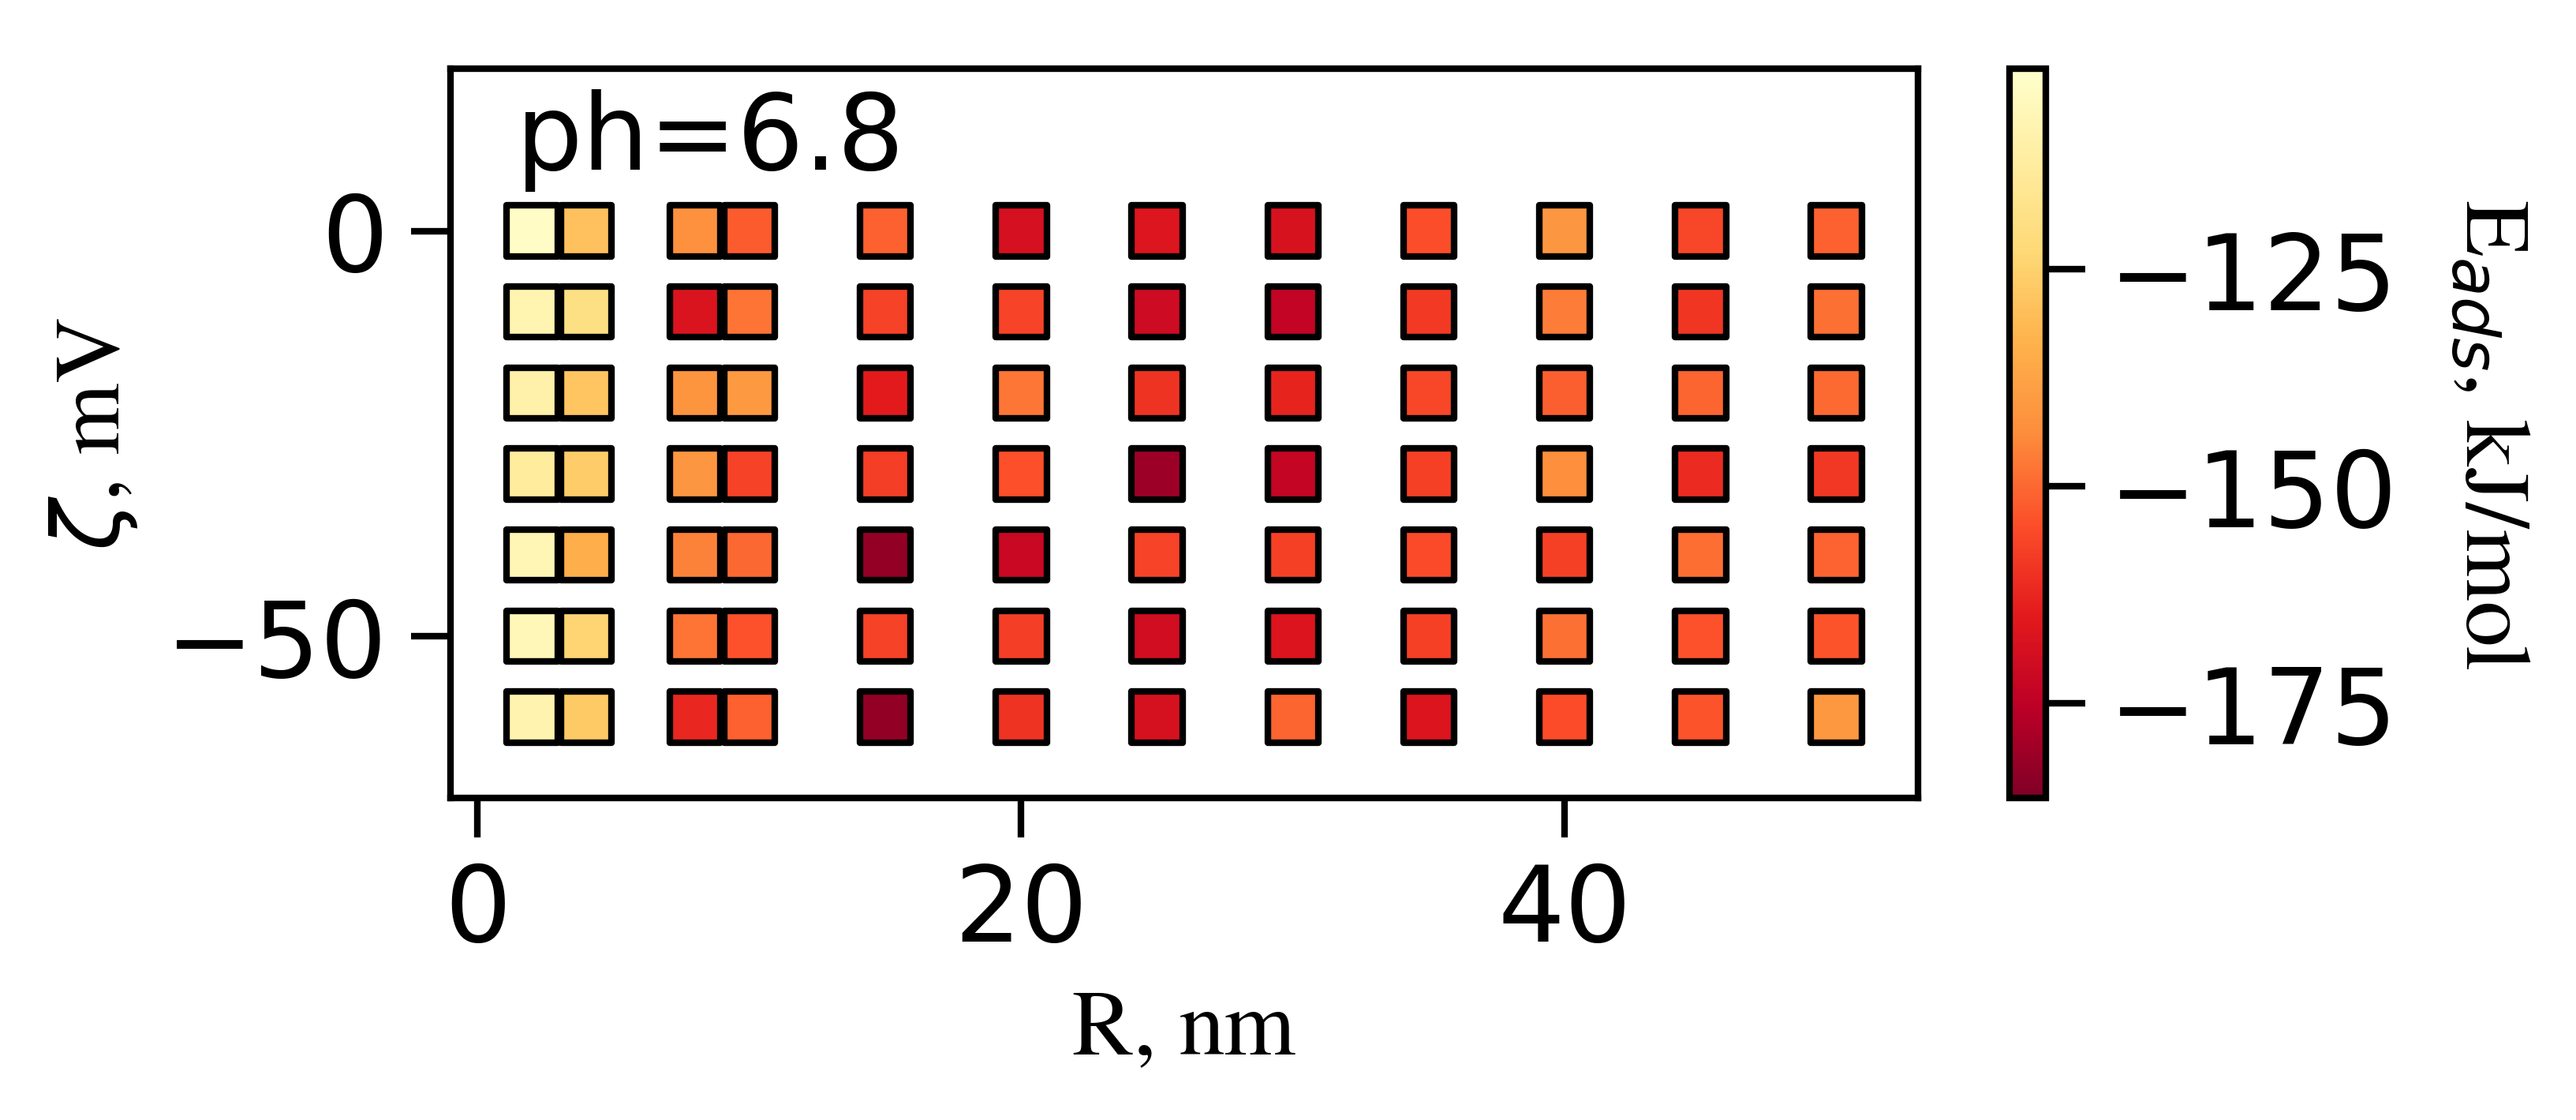

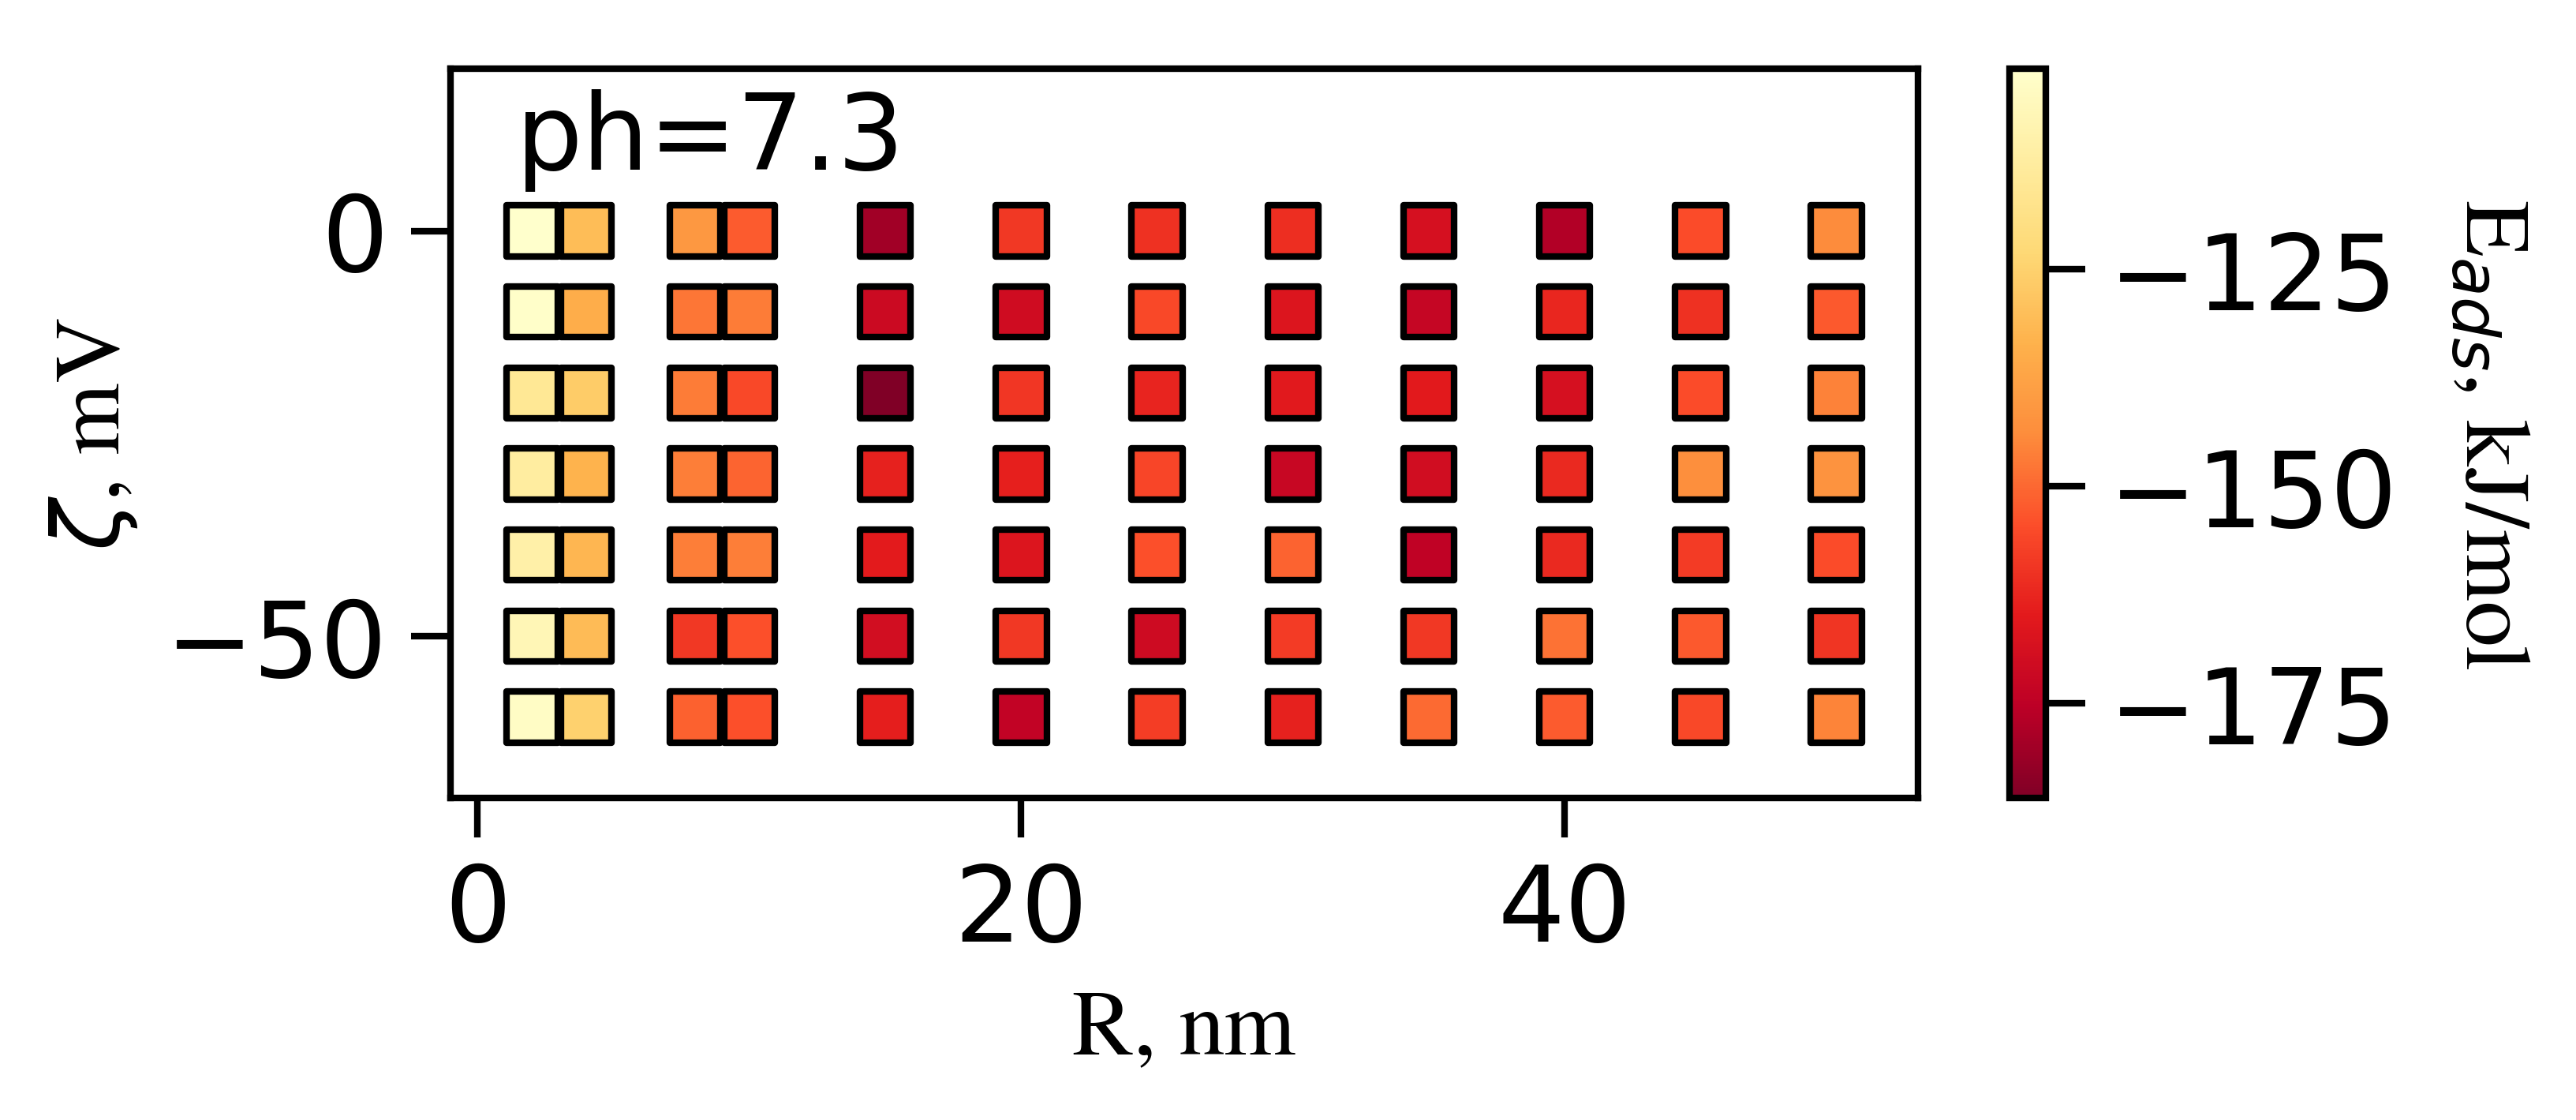

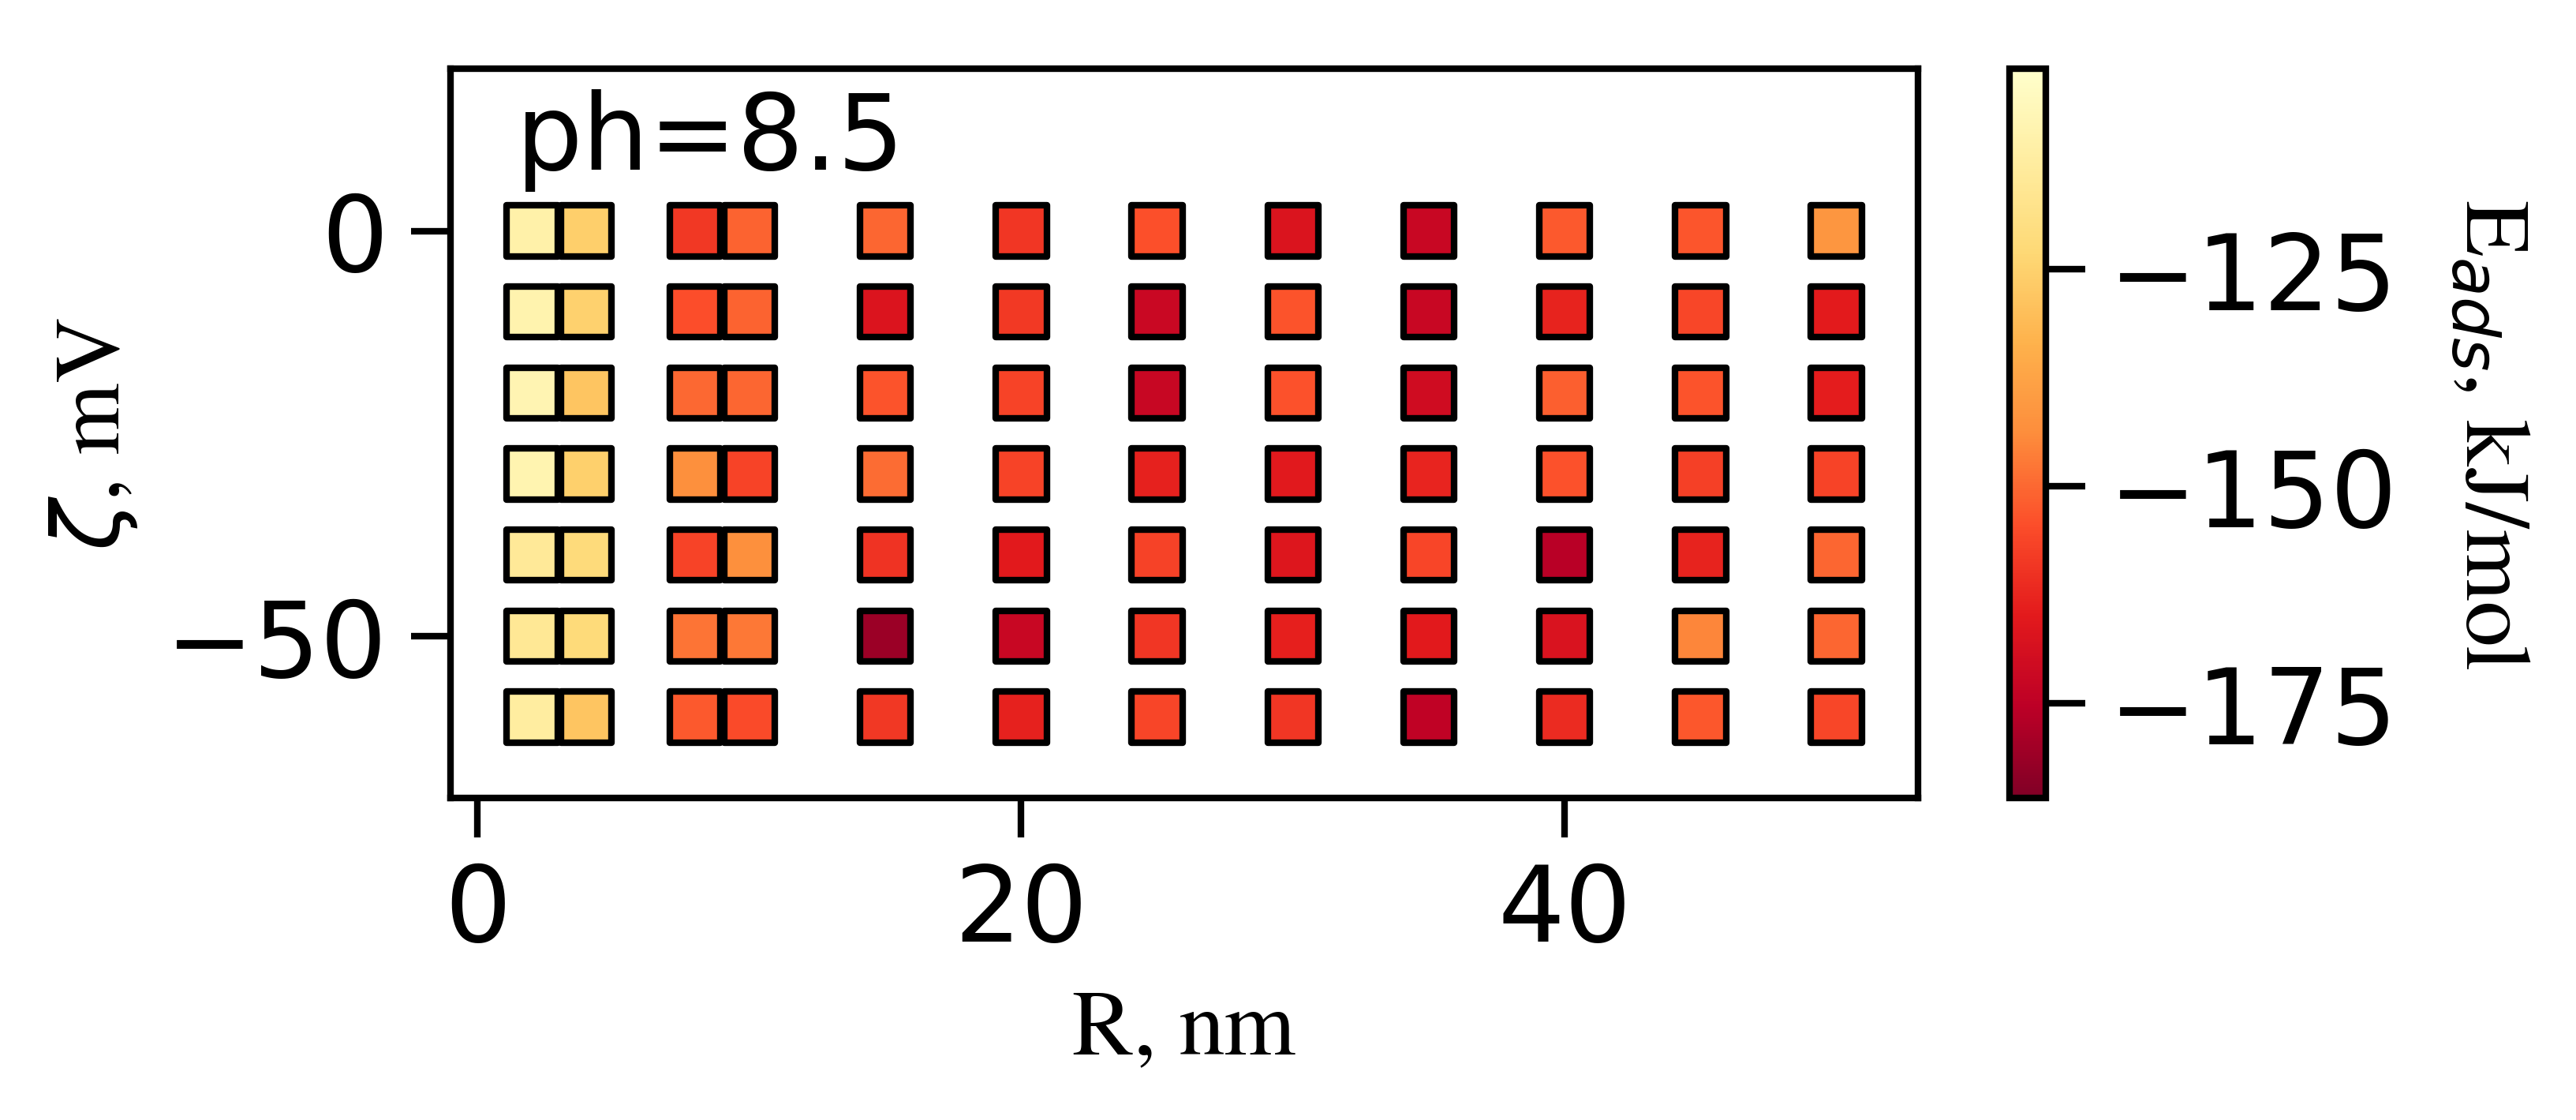

In [24]:
font_path = "/usr/share/fonts/truetype/freefont/FreeSerif.ttf"
fontsize  = 20
clabelpad = 20
font      = mfm.FontProperties(fname = font_path, size = fontsize)
font2      = mfm.FontProperties(fname = font_path, size = 14)
tickFont      = mfm.FontProperties(fname = font_path, size = 14, weight="bold")
xlabel    = "R, nm"
ylabel    = r'$\zeta$'+", mV"
cm = plt.cm.get_cmap('RdYlBu')
clabel    = r"E$_{ads}$, kJ/mol"


vmin=df.loc[df['ph'] == min_ph].eads.min()
vmax=df.loc[df['ph'] == min_ph].eads.max()

for val in pH:
    df_plot=df.loc[df['ph'] == val]
    fig = plt.figure(figsize=(5, 2))
    ax = fig.add_subplot(111)
    cm = plt.cm.get_cmap('YlOrRd_r')
    sc = plt.scatter(df_plot.r, df_plot.zp, c=df_plot.eads, vmin=vmin, vmax=vmax, s=60, marker="s", cmap=cm,
                    edgecolor='black', linewidth=1)
    plt.ylim([-70, 20])
    plt.xlim([-1, max(R)+3])
    cb = plt.colorbar(sc)
    cb.set_label(clabel, rotation = 270, labelpad = clabelpad, fontproperties = font2)
    plt.xlabel(xlabel, fontproperties = font2)
    plt.ylabel(ylabel, fontproperties = font2)
    plt.legend(loc='lower left', bbox_to_anchor=(-0.02, 0.63), title="ph={}".format(val), frameon=False)
    plt.savefig(assetsDir+'{}_r_zp_eads.png'.format(val), format='png', dpi=res_png,  transparent=True, bbox_inches='tight')

![6.8_r_zp_eads.png](nb_assets/6.8_r_zp_eads.png)
![7.3_r_zp_eads.png](nb_assets/7.3_r_zp_eads.png)
![8.5_r_zp_eads.png](nb_assets/8.5_r_zp_eads.png)

## 2.2. Assigning absolute minima for all heatmaps to rotational coordinates/IgG orientation in respect to surface of AgNP (Fig.7 in text)

Plot lowest minimas from all heatmaps as a function of rotational coordinates psi and theta (Fig.7 in text).

--to identify corresponding geometry of protein-NP complex;

--use difrent colors to highligh thier locations and orientation;

-- the color of the marker coresponds to the adsorbtion energy value:

-- the darker, the stronger the interaction for a specific orientation;

-- add callouts to each marker to tag with zeta potential and NP size.

In [26]:
#these orientations were visually tested with web tool to identify 
#the closest to NP units of IgG (as they marked in Fig. 5 in the text)

sites=[
[[5,100],"Fab1 + Fab2 + Fc","purple"],
[[0,170],"Fab2 + Fc", "red"],
[[10,130],"Fab2 + Fc","red"],
[[115,40], "Fab1", "blue"],
[[120,65], "Fab1 + Fab2", "green"],
[[120,120], "Fab2", "blue"],
[[85,85], "Fab2", "blue"],
[[85,100], "Fab2", "blue"],
[[175,36], "Fab2 + Fc", "red"],
[[260,170], "Fab2 + Fc", "red"],
[[355,170], "Fab2 + Fc", "red"],
[[275,55], "Fab1 + Fc", "red"],
[[260,110], "Fc", "#00CED1"],
]

In [27]:
new_sites=[] # this array will be used below

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1131430/3597597433.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse  = patches.Ellipse((origin[0], origin[1]), width, height, angle=angle, color=sites[-1][2], alpha=0.1, fill=True,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


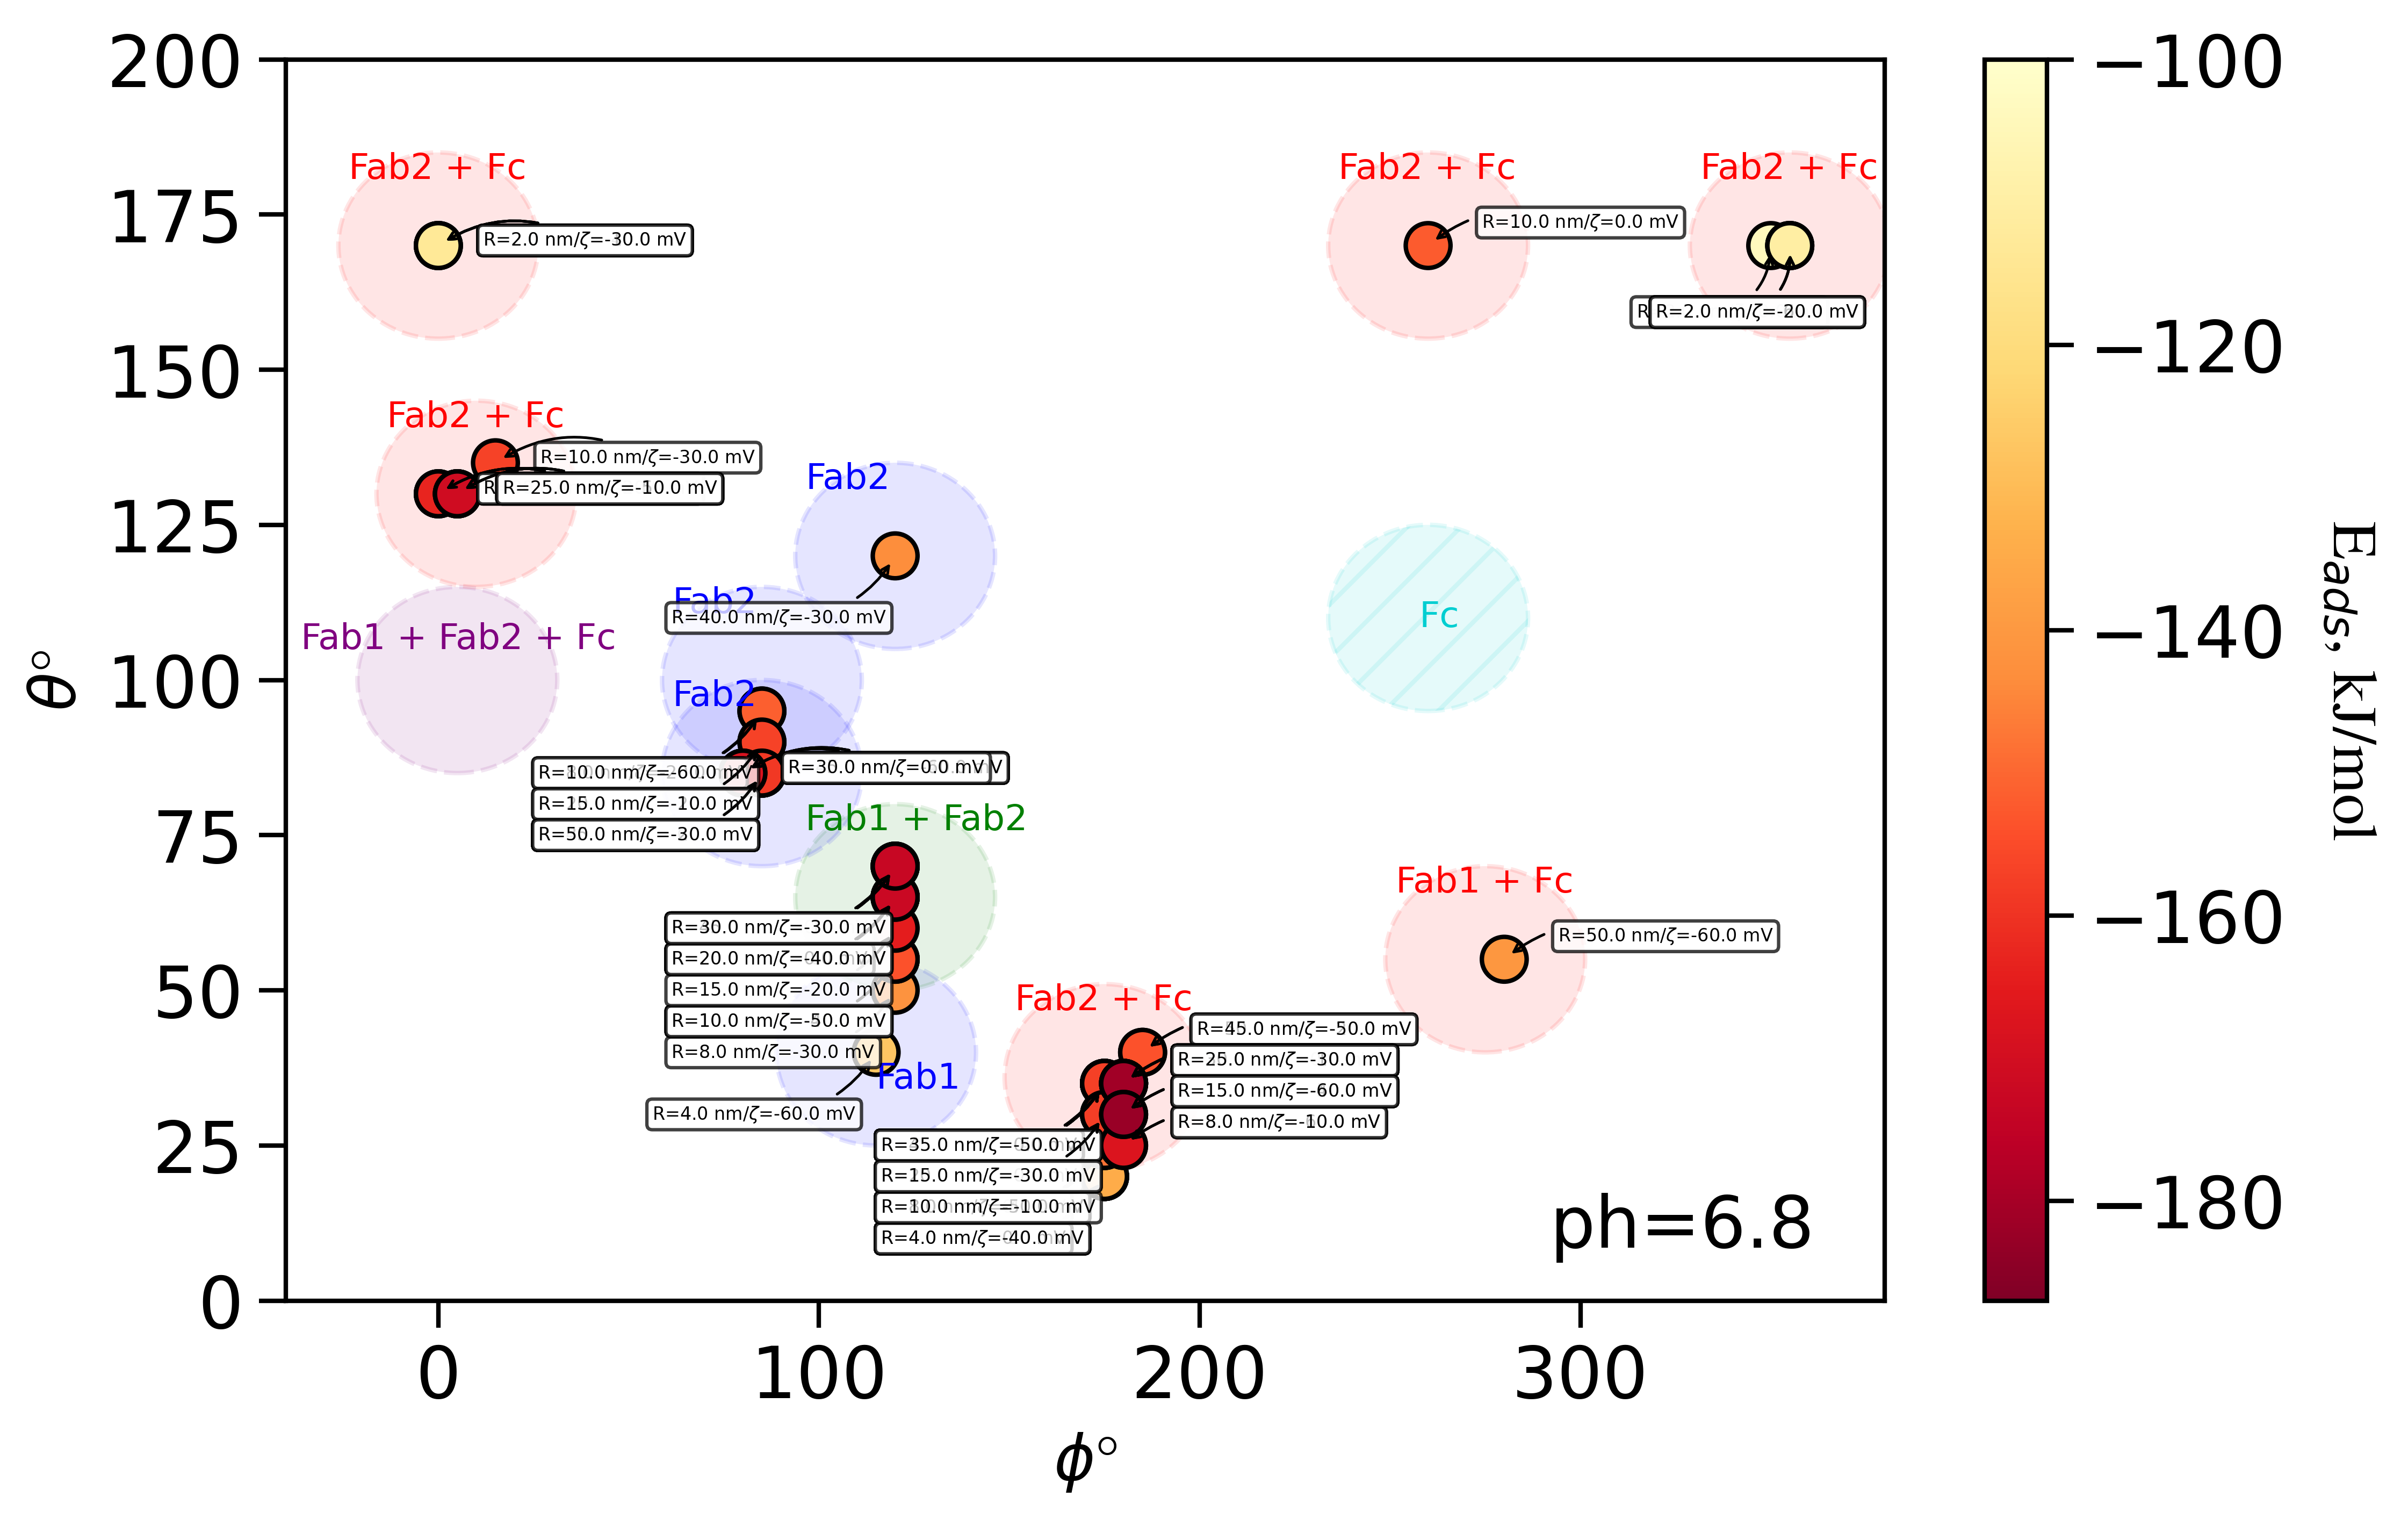

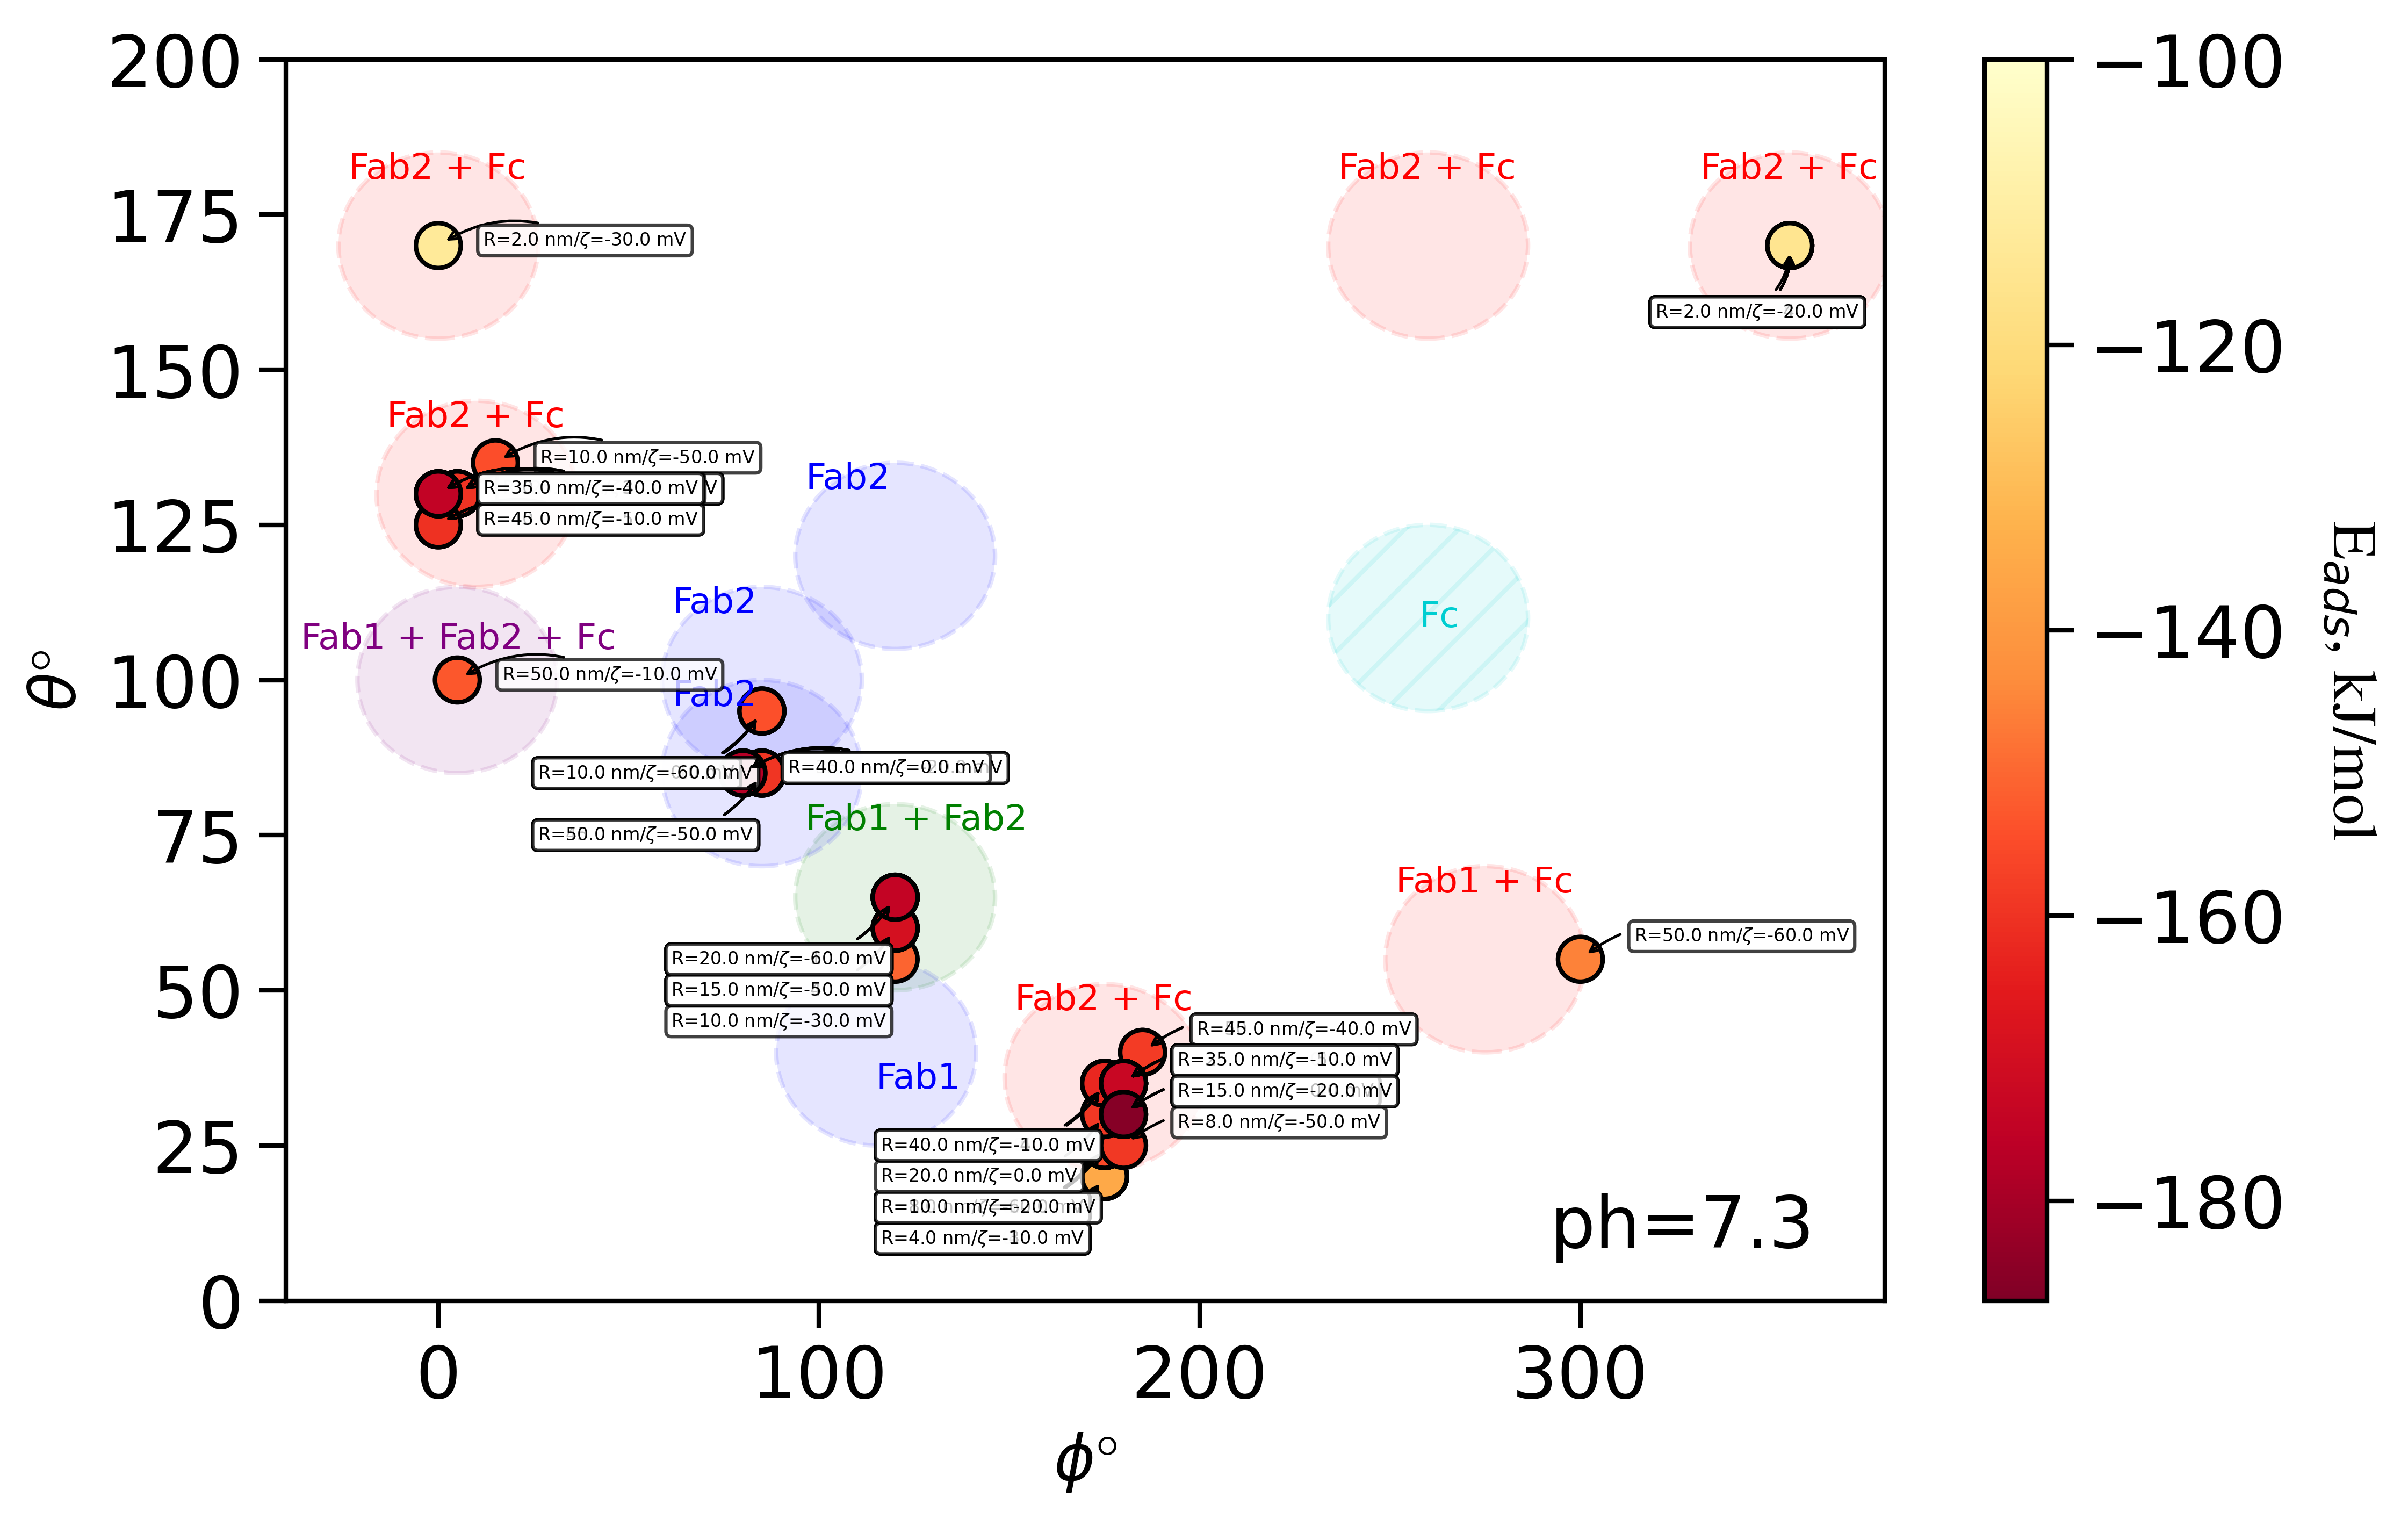

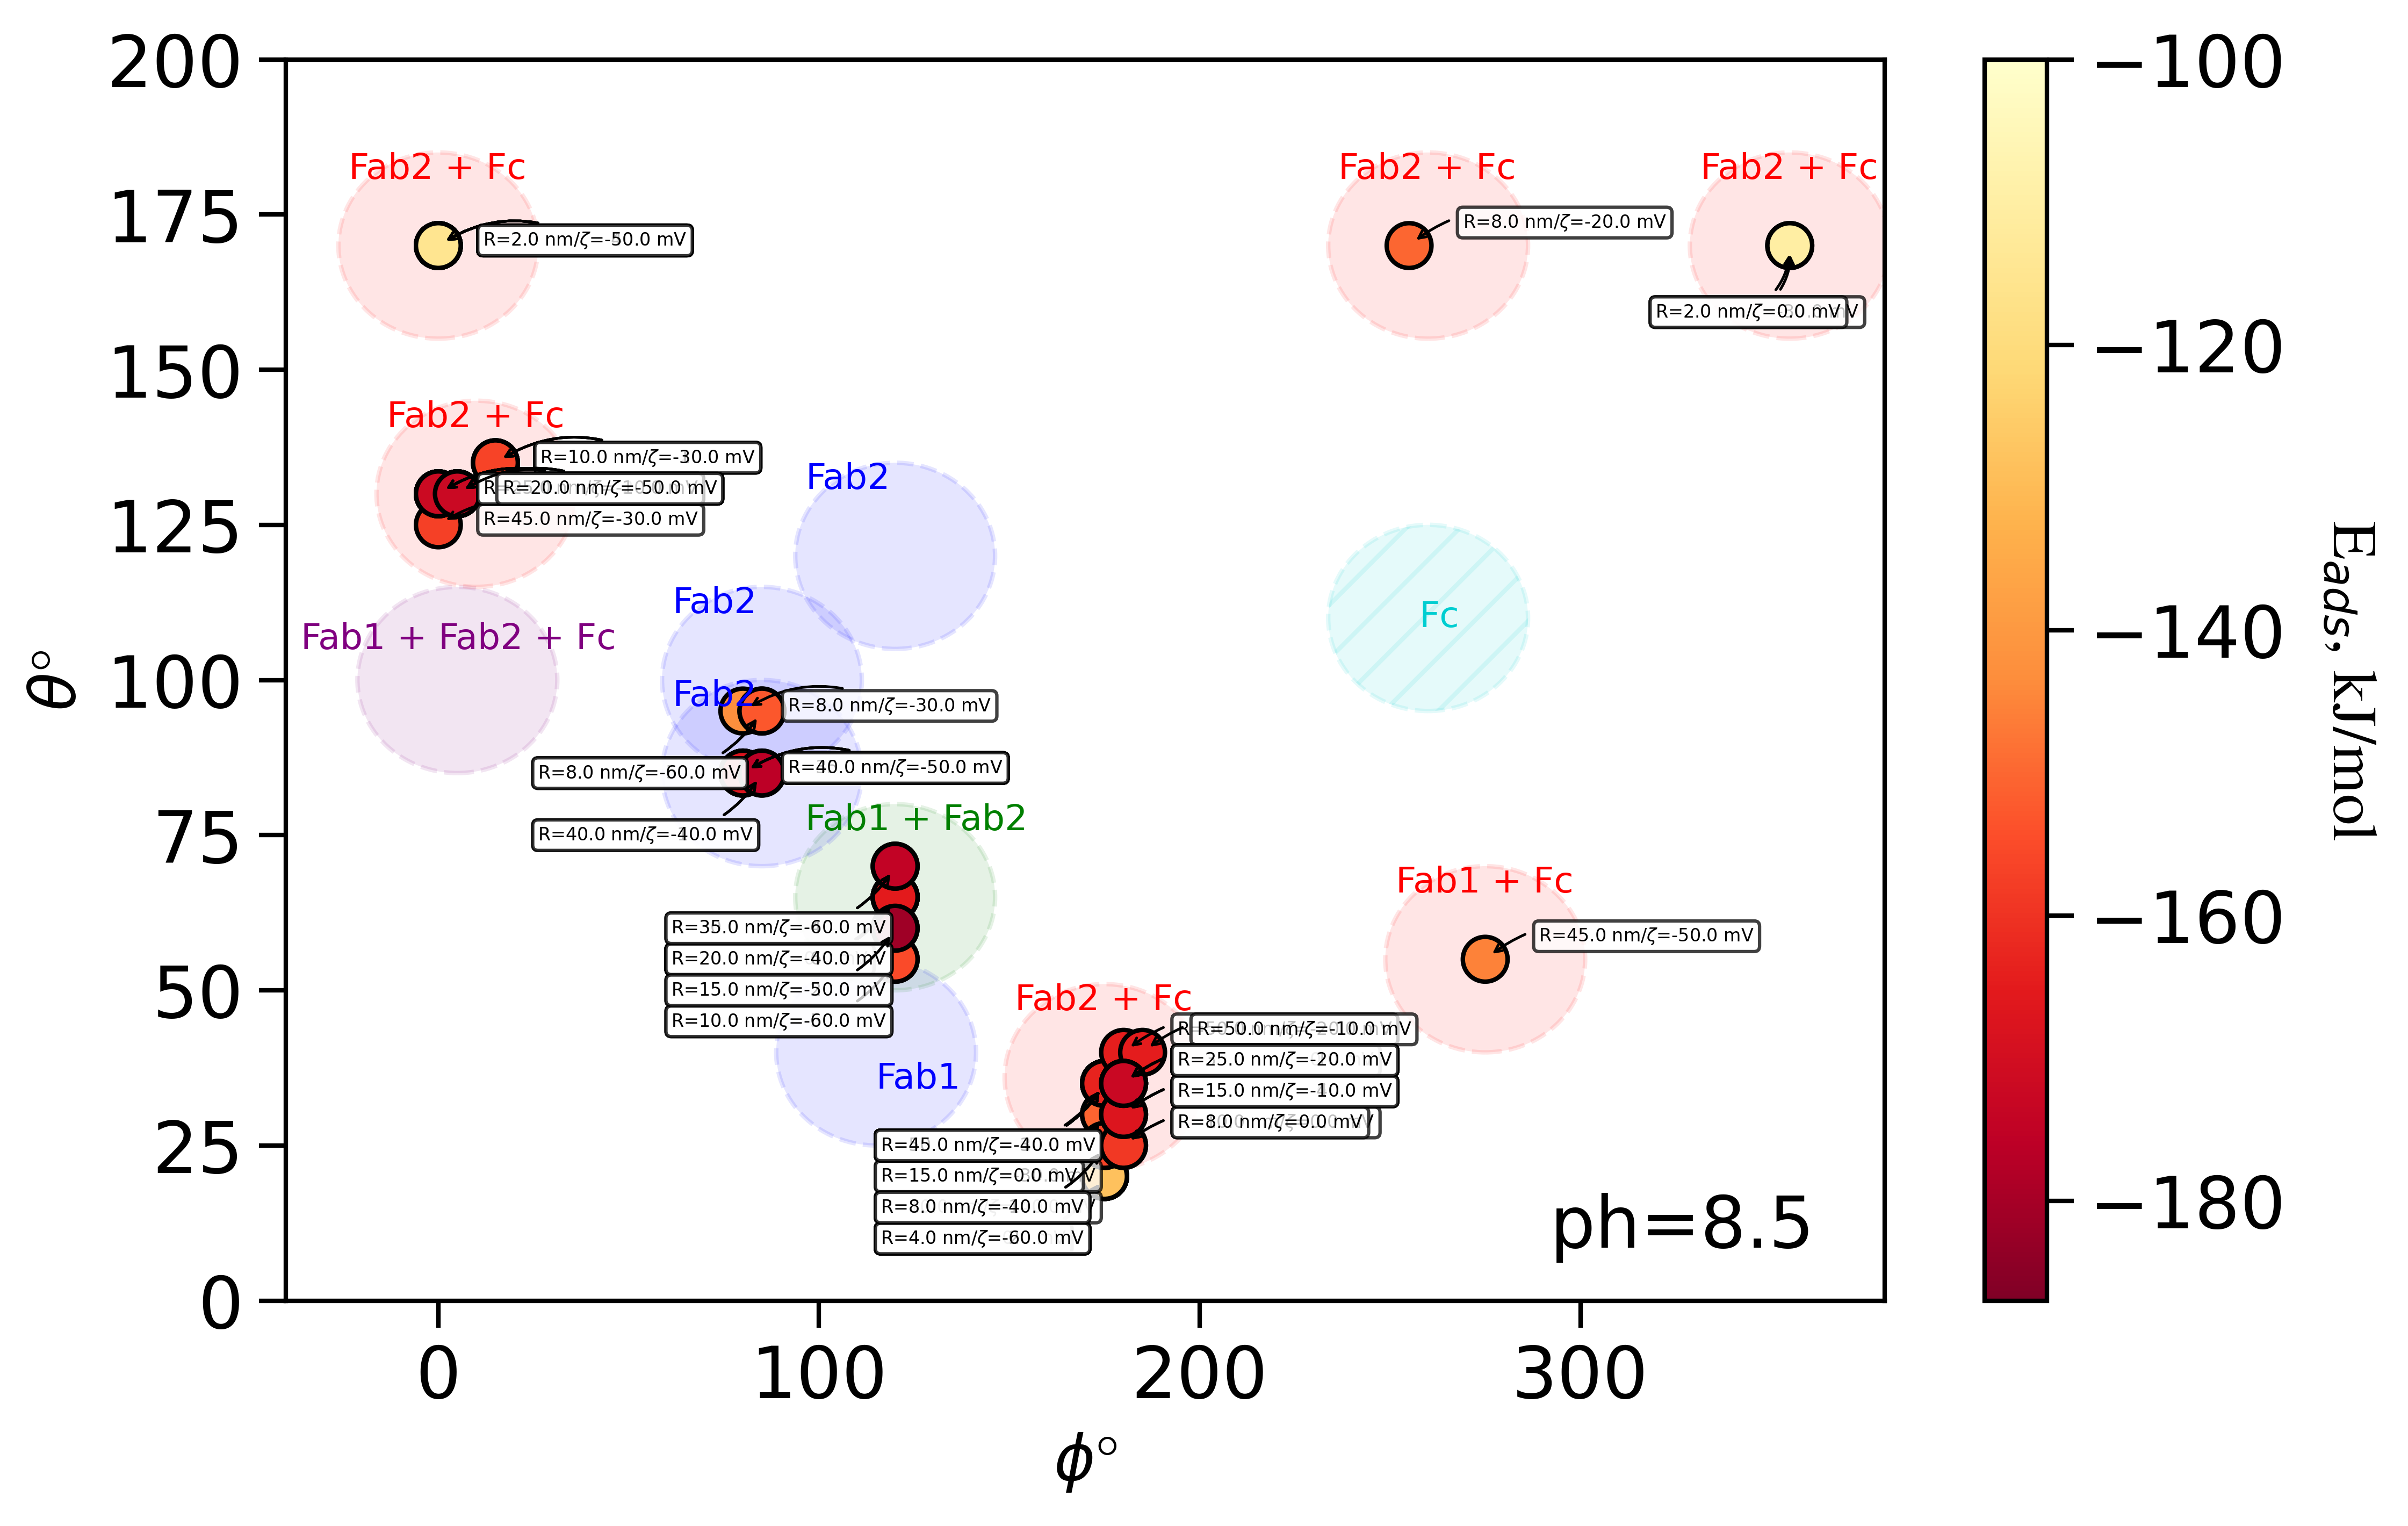

In [28]:
#change vmin/vmax for color bar to see difrence between all minimas
vmin=-100
vmax=-170
xlabel    = r"$\phi$" + u"\u00B0"
ylabel    = r"$\theta$" + u"\u00B0"

elipse_font_label=8
for val in pH:
    df_plot=df.loc[df['ph'] == val].sort_values(by=e_to_check, ascending=False)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    cm = plt.cm.get_cmap('YlOrRd_r')
    
    #Place areas
    radius = 15
    width, height = radius*3.5, radius*2
    angle = 0 

    #Plot position of  local minima found at map. thier positions are listed in "sites" array
    
    for s,site in enumerate(sites[:12]):
        origin=site[0]
        ellipse  = patches.Ellipse((origin[0], origin[1]), width, height, angle=angle, color=site[2], alpha=0.1, fill=True,
                                linestyle='--', linewidth=1)
        plt.gca().add_patch(ellipse )
        
        xytext_ellipse=(-20, 15)
        
        if s==0:
            xytext_ellipse=(-35, 7) 
            
        if s==3:
            xytext_ellipse=(0, -8)

            
        ax.annotate(site[1], xy=(origin[0], origin[1]), 
                    xytext=xytext_ellipse, textcoords='offset points',
                     fontsize=elipse_font_label,
                    color=site[2])

    
    sc = plt.scatter(df_plot.psi, df_plot.theta, c=df_plot.eads, vmin=vmin, vmax=vmax, s=100, cmap=cm,
                    edgecolor='black', linewidth=1)
    
    
    plt.ylim([0, 200])
    plt.xlim([-40, 380])
    cb = plt.colorbar(sc)
    cb.set_label(clabel, rotation = 270, labelpad = clabelpad, fontproperties = font2)
    plt.xlabel(xlabel, fontproperties = font2)
    plt.ylabel(ylabel, fontproperties = font2)
    plt.legend(loc='lower left', bbox_to_anchor=(0.75, -0.05), title="ph={}".format(val), frameon=False)
    
    for indx in df_plot.index:
        label=("R={} nm/".format(df_plot.r[indx])+r'$\zeta$'+"={} mV".format(df_plot.zp[indx]))
        x=df_plot.psi[indx]
        y=df_plot.theta[indx]
        if x <=175:
            xy_text=(-50, -15)
            
        if x <=80:
            xy_text=(10, 0)     

        if x >175:
            xy_text=(12, 4)
        if x >300:
            xy_text=(-30, -16)            
        
        new_sites.append([val, x, y, df_plot.eads[indx]])
        
        plt.annotate(label, (x, y), textcoords="offset points", 
                     xytext=xy_text,
                     ha='left',  
                     fontsize=4, 
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white',alpha=0.75, linewidth=0.75), # Add a box around the text
                     arrowprops=dict(arrowstyle="->", color='black', linewidth=0.6,
                                    connectionstyle="arc3,rad=0.3"))

    #Plot position of desired orientaton

    origin=sites[-1][0]
    ellipse  = patches.Ellipse((origin[0], origin[1]), width, height, angle=angle, color=sites[-1][2], alpha=0.1, fill=True,
                            linestyle='--', linewidth=1,
                            edgecolor=sites[-2][0], facecolor='none', hatch='//'
                           )
    plt.gca().add_patch(ellipse)
    ax.annotate(sites[-1][1], xy=(origin[0], origin[1]), 
                xytext=(-2, -2), textcoords='offset points',
                 fontsize=elipse_font_label,
                color=sites[-1][2])
        
    plt.savefig(assetsDir+'{}_r_rot.png'.format(val), format='png', dpi=res_png,  transparent=True, bbox_inches='tight')
    
    
    
    
    

![6.8_r_rot.png](nb_assets/6.8_r_rot.png)
![7.3_r_rot.png](nb_assets/7.3_r_rot.png)
![8.5_r_rot.png](nb_assets/8.5_r_rot.png)

## 2.3. Plotting heatmap for best adsorbtion conditions (pH=7.3, R=20 nm, zPot=-15mV) and checking in all possible docking poses within 1SD interval (Fig.9 in text)

Now, let's analyse the lowest energy docking pose for `IgG-AgNP` complex.
First we need to find all required files - `.uam`, `.pdb`, `.np` for `min_ph`, which is `7.3`

In [30]:
val=min_ph
radii_core=min_r

parent_dir="."
resFolder = parent_dir+"/scaleup/res/"
pdbFolder = parent_dir+"/web/{}/".format(val)
npFolder  = parent_dir+"/scaleup/res/{}/nps/configs/{}_ag111.config_NPs/".format(val,val)
pdbs=[]
nps=[]
for pr in os.listdir(pdbFolder):
    if pr.endswith(".pdb"):
        if "propKa2UA" in pr:
            pdbs.append(pr)
            
for pr in os.listdir(npFolder):
    if pr.endswith(".np"):
        if str(int(min_r))  in pr:
            if str(int(min_zp))  in pr:
                nps.append(pr)

Select `.uam` for conditions with the lowest adsorbtion energy:

In [31]:
uamIn=uamsArr[0]
pdbIn=pdbFolder+pdbs[0]
npIn=npFolder+nps[0]

In [32]:
uamIn

'./scaleup/res/7.3/np31R_15_ZP_-20/propKa2UA_15_-20.uam'

In [33]:
pdbIn

'./web/7.3/propKa2UA.pdb'

In [34]:
npIn

'./scaleup/res/7.3/nps/configs/7.3_ag111.config_NPs/np31R_15_ZP_-20.np'

Now lets plot heatmap and annotate it:

In [ ]:
rawData         = np.genfromtxt(uamIn)
phiData         = rawData[:,0]
thetaData       = rawData[:,1]
#energy          = rawData[:,2] #kbt
energy          = rawData[:,6] #kJ/mol
sdData          = rawData[:,3]
ssdData         = rawData[:,4]
sinTheta        = np.sin(thetaData * np.pi / 180.0)
boltzmanAverage = np.sum(energy * sinTheta * np.exp(-1.0 *  energy)) / np.sum(sinTheta * np.exp(-1.0 * energy))
simpleAverage   = np.mean(sinTheta * energy)
index           = np.argmin(energy)
delta           = phiData[1] - phiData[0]
rows            = int(180. / delta)
cols            = int(360. / delta)
image           = np.zeros((rows, cols))

#Select first lowest conformation
conf_id = 0
conf_phi = phiData[index]
conf_theta = thetaData[index]
conf_ssd = ssdData[index]
conf_ene = energy[index]
conf_sd  = sdData[index]

We can shadow all areas on the heatmap (below) that is within `1SD` interval
 to find what are other possible oreintations.

In [36]:
n_SD=1
isovalue=conf_ene+n_SD*abs(conf_sd)*2.459 

These are locations of precise positions of local minima:

In [37]:
min_pos=[
 [[180.0, 30.0,], 'Fab2 + Fc', 'a'],
 [[120.0, 60.0], 'Fab1 + Fab2', 'b'],
 [[85.0, 90.0], 'Fab2', 'c'],
 [[215.0, 40.0], "Fab1", "d"],
 [[20.0, 130.0],"Fab2 + Fc","e"],
 [[280,45], "Fab1 + Fc", "f"],
 [[300.0, 165.0], "Fab2 + Fc", "g"],
 [[260,110], "Fc", "h"],
]

Let's plot heatmap with annotations (`Fig.9` in text):

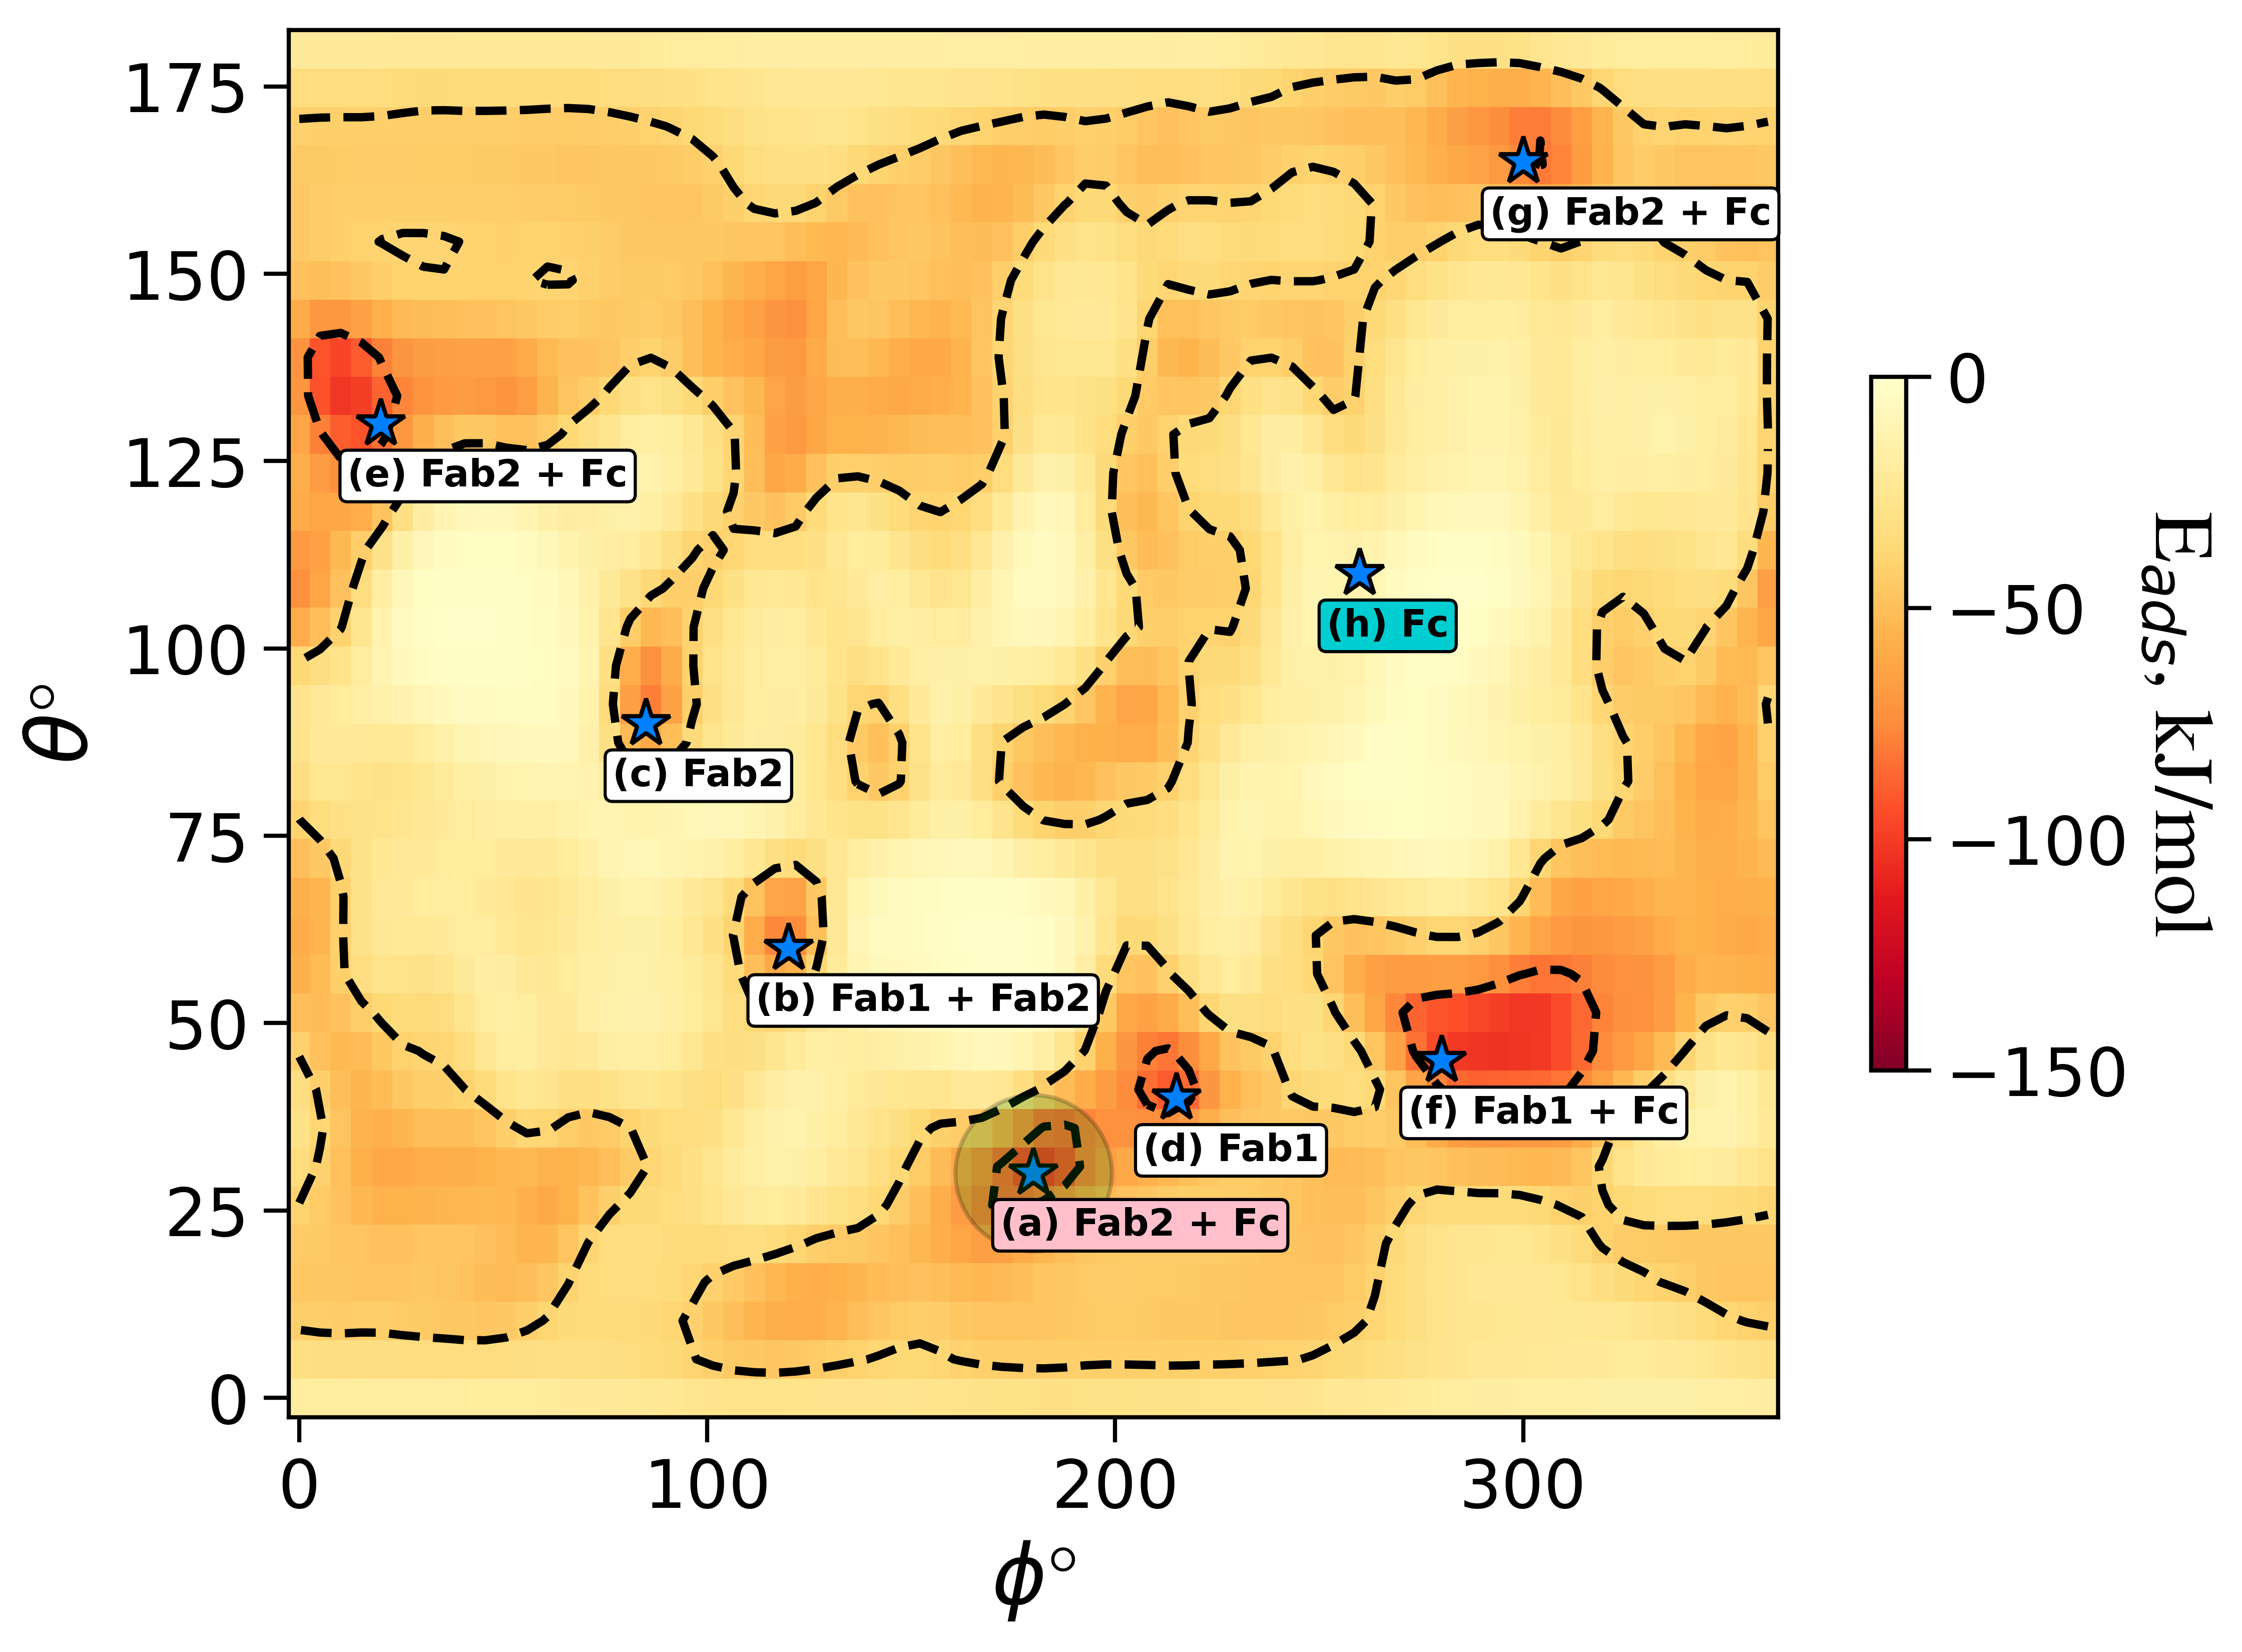

In [38]:
phi_hatch=[]
theta_hatch=[]
for phi, theta , energy , sd ,ssd, mfpt ,energy_kj, prot_surf_com_dist, omega, n_cont, com_com_min in rawData:
    row             = int(theta / delta)
    col             = int(phi / delta)
    image[row][col] = energy_kj #energy in kJ/mol
    if energy_kj <= isovalue:
        phi_hatch.append(phi)
        theta_hatch.append(theta)

lon = np.linspace(0, 360, cols)
lat = np.linspace(0, 180, rows)
Lon, Lat = np.meshgrid(lon,lat)
image = sp.ndimage.gaussian_filter(image, sigma = [1.0, 1.0], mode = ['constant', 'wrap'])



# Plot the data
font_path = "/usr/share/fonts/truetype/freefont/FreeSerif.ttf"
fontsize  = 20
clabelpad = 20

font      = mfm.FontProperties(fname = font_path, size = fontsize)
tickFont      = mfm.FontProperties(fname = font_path, size = 14, weight="bold")
xlabel    = r"$\phi$" + u"\u00B0"
ylabel    = r"$\theta$" + u"\u00B0"

vmax=0
vmin=-150
fig = plt.figure()
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('YlOrRd_r')
im = ax.pcolormesh(Lon, Lat, image, cmap = cm)

im.set_clim(vmin=vmin, vmax=vmax)


plt.contour(Lon, Lat, image, 2, colors='k')


cb = fig.colorbar(im, ax = ax, shrink = 0.5)
cb.set_label(clabel, rotation = 270, labelpad = clabelpad, fontproperties = font)
ax.set_xlabel(xlabel, fontproperties = font)
ax.set_ylabel(ylabel, fontproperties = font)
ax.tick_params(tick1On=True)



for i,_ in enumerate(min_pos):
    c_phi, c_theta =min_pos[i][0]    
    ax.plot(c_phi, c_theta, "gold", marker='*', markersize=12, markeredgecolor="k", markerfacecolor="#007FFF")
    an_label="({}) {}".format(min_pos[i][2],min_pos[i][1])    
    if  c_phi==260 and c_theta == 110:
        facecolor='#00CED1'
    else:
        if c_phi==min_psi and c_theta == min_theta:
            facecolor='pink'
        else:
            facecolor='white'
        
    ax.annotate(an_label, xy=(c_phi, c_theta), 
                    xytext=(-8, -15), textcoords='offset points',
                     ha='left',  
                    weight="bold", 
                    fontsize=9,  
                   bbox=dict(boxstyle="round,pad=0.2", edgecolor='black', facecolor=facecolor, linewidth=0.75),
                   )

#here we can shadow
for h,_ in enumerate(phi_hatch):
    plt.plot(phi_hatch[h],theta_hatch[h],marker=".", markersize=75, alpha=.2,
             markeredgecolor="k", markerfacecolor="green")

    
plt.savefig(assetsDir+'ph{}_R{}_ZP{}_heatmap.png'.format(min_ph,min_r,min_zp), format='png', dpi=res_png,  transparent=True, bbox_inches='tight')

![ph7.3_R15.0_ZP-20.0_heatmap.png](nb_assets/ph7.3_R15.0_ZP-20.0_heatmap.png)

Note, that no shadowed docking poses other than absolute minimum were located for selected heatmap within `1SD `interval:

In [41]:
for h,_ in enumerate(phi_hatch):
    print([phi_hatch[h],theta_hatch[h]])

[180.0, 30.0]


## 2.4. Visualisation of the lowest energy docking pose at phi=180, theta=30 (Fig.8a in text)

Script below is based on the script from  `NPCoronaPredict` distribution which is used for reconstraction of protein-NP complex inmplemented in UANanoDock. For more information [visit GitHub page](https://github.com/ucd-softmatterlab/NPCoronaPredict/tree/main/tools/VisualiseUAResults). Other poses can be produced in a simmilar manner by scrolling through all `pose_id` in `min_pos` array.

In [48]:
pose_id=0
[conf_phi, conf_theta],label, letter = min_pos[pose_id]
conf_phi, conf_theta

(180.0, 30.0)

In [49]:
 dic_ua={
     "phi":"",
     "theta":"",
     "energy":"",
     "sd":"",
     "ssd":"",
     "mfpt":"",
     "energy_kj":"",
     "prot_surf_com_dist":"",
     "omega":"",
     "n_cont":"",
     "com_com_min":""}

In [50]:
col_names_ua=list(dic_ua.keys())

In [51]:
df_uam = pd.DataFrame(rawData,columns=col_names_ua)
df_uam

phi  theta    energy       sd      ssd  mfpt  energy_kj  \
0       0.0    0.0  -9.67789  0.57252  0.36548  -1.0  -24.13993   
1       5.0    0.0  -9.63757  0.82463  0.37098  -1.0  -24.03938   
2      10.0    0.0  -9.94276  0.65340  0.36526  -1.0  -24.80061   
3      15.0    0.0  -9.35345  0.07376  0.37240  -1.0  -23.33068   
4      20.0    0.0 -10.19374  0.82463  0.35718  -1.0  -25.42663   
...     ...    ...       ...      ...      ...   ...        ...   
2587  335.0  175.0  -9.95792  0.23280  0.37553  -1.0  -24.83842   
2588  340.0  175.0  -9.96533  0.26366  0.38268  -1.0  -24.85691   
2589  345.0  175.0 -10.13931  0.37879  0.38128  -1.0  -25.29088   
2590  350.0  175.0 -10.22899  0.39718  0.37910  -1.0  -25.51456   
2591  355.0  175.0 -10.30130  0.41091  0.38248  -1.0  -25.69493   

      prot_surf_com_dist  omega   n_cont  com_com_min  
0               15.36548    0.0  2.16667     24.55412  
1               15.37098    0.0  2.00000     24.54744  
2               15.36526    0.0  2.33333     24.56743  
3               15.37240    0.0  2.50000     24.53644  
4               15.35718    0.0  2.83333     24.56156  
...                  ...    ...      ...          ...  
2587            15.37553    0.0  2.00000     21.34268  
2588            15.38268    0.0  2.00000     21.33911  
2589            15.38128    0.0  2.00000     21.36753  
2590            15.37910    0.0  2.00000     21.37671  
2591            15.38248    0.0  2.00000     21.39610  

[2592 rows x 11 columns]

We need this surface-surface separation distance (`SSD`) to place protein at the right distance away from the nanosurface:

In [52]:
conf_ssd=df_uam.loc[df_uam['phi'] == conf_phi].loc[df_uam['theta'] == conf_theta].ssd.values[0]

These function correspons to  `UA` rotation (see appendix `"A.1 The UA rotation convention"` at page `26` in original UAModel [manual](https://github.com/ucd-softmatterlab/NPCoronaPredict/blob/main/docs/NPCoronaPredictManual.pdf)). Note that it will be already applied to aligned pdb (`propKa2UA.pdb`). If the user wants to start reconstruction of protein-NP complex from "raw" `PDB`, he/she should apply canonical rotation to this `PDB` as described [here](https://github.com/ucd-softmatterlab/NPCoronaPredict/blob/main/RotateProteinToCanonical.py).

In [54]:
def rotatePDB(coords,phi,theta):
    rxx = np.cos(theta)*np.cos(phi)
    rxy = -1 * np.cos(theta)*np.sin(phi)
    rxz = np.sin(theta)
    ryx = np.sin(phi)
    ryy = np.cos(phi)
    ryz = 0
    rzx = -1*np.sin(theta)*np.cos(phi)
    rzy = np.sin(theta)*np.sin(phi)
    rzz = np.cos(theta)
    finalCoords = np.zeros_like(coords)
    
    finalCoords[:,0] = coords[:,0] * rxx + coords[:,1] * rxy + coords[:,2]*rxz 
    finalCoords[:,1] = coords[:,0] * ryx + coords[:,1] * ryy + coords[:,2]*ryz 
    finalCoords[:,2] = coords[:,0] * rzx + coords[:,1] * rzy + coords[:,2]*rzz 
    return finalCoords

In [55]:
def tUACOM():
    def wrapped(ts):
        ts.positions += np.array(  [ -np.mean(ts.positions[:,0]) ,- np.mean(ts.positions[:,1]), -np.mean(ts.positions[:,2])  ]  )
        return ts
    return wrapped
       
def tUARotate(phi,theta):
    def wrapped(ts):
        ts.positions = rotatePDB(ts.positions,phi,theta)
        return ts
    return wrapped

def tUAZShift(dz):
    def wrapped(ts):
        ts.positions += np.array( [0.0,0.0,dz - np.amin(ts.positions[:,2])])
        return ts
    return wrapped

Now read in the protein and apply transformations:

In [57]:
pdbIn

'./web/7.3/propKa2UA.pdb'

In [58]:
u_prot = Universe(pdbIn)

/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [59]:
minTheta = conf_theta  + 2.5
minPhi = conf_phi + 2.5
rot_phi   = -1.0 * minPhi  * (np.pi / 180.0)
rot_theta = (180.0 - minTheta) * (np.pi / 180.0)

In [60]:
translateToCOM = tUACOM()
applyRotation = tUARotate( rot_phi, rot_theta)
translateToSurface = tUAZShift( 10*(radii_core+conf_ssd) )
u_prot.trajectory.add_transformations(*[translateToCOM,applyRotation,translateToSurface])

In [61]:
u_rot = mda.Universe.empty(u_prot.atoms.n_atoms,
                         n_residues=u_prot.atoms.n_residues,
                         atom_resindex=u_prot.atoms.resindices,
                         residue_segindex=u_prot.residues.segindices,
                         trajectory=True)
u_rot.add_TopologyAttr('name', u_prot.atoms.names)
u_rot.add_TopologyAttr('type', u_prot.atoms.types)
u_rot.add_TopologyAttr('elements', u_prot.atoms.names.astype('<U1'))
u_rot.add_TopologyAttr('resname', u_prot.residues.resnames)
u_rot.add_TopologyAttr('resid', u_prot.residues.resids)

Then, read in `.np` file to add to complex and save as a `PDB`:

In [62]:
elemDic={"AG": "Ag"}
typeDic={"AG": "Ag"}
beadDicRGB={"Ag": [0.86, 0.86, 0.86]}
beadDicHex={"Ag": "#DCDCDC"}

In [63]:
rawNPCoor         = np.genfromtxt(npIn,  delimiter=',' , skip_header=2, dtype=None, encoding=None)
rawNPDef         =  np.genfromtxt(npIn,  delimiter=',' , skip_header=1, skip_footer=1, dtype=None, encoding=None)

In [64]:
i=1
NPcoordList=[]
NPresNameArray=[]
NPRad=[]

In [65]:
_,npR,  zeta, _, _, _, _, _, _, _= rawNPDef.tolist()

In [66]:
i=1
npX = 0
npY = 0
npZ = 0
solid=core
NPresNameArray.append([solid.upper(), solid.upper(), int(i)])
NPcoordList.append([float(round(npX,3)*10), float(round(npY,3)*10), float(round(npZ,3)*10)])
NPRad.append([int(i), solid.upper(), float(npR)])

In [68]:
NPcoord=np.array(NPcoordList)
NPres=np.array(NPresNameArray)
NPRs=np.array(NPRad)

In [69]:
nameLst=[]
resLst=[]
typeLst=[]
elemLst=[]
coorArr=[]
for i, line in enumerate(NPres):
    typeLst.append(typeDic[line[0]])
    elemLst.append(elemDic[line[0]])
    nameLst.append(line[0])
    resLst.append(line[1])
    coorArr.append(NPcoord[i])
n_residues = len(NPres)
n_atoms = len(NPres)
resindices = np.repeat(range(n_residues), 1)
assert len(resindices) == n_atoms
segindices = [0] * n_residues
u_nano = mda.Universe.empty(n_atoms,
                         n_residues=n_residues,
                         atom_resindex=resindices,
                         residue_segindex=segindices,
                         trajectory=True) 
u_nano.add_TopologyAttr('name', nameLst)
u_nano.add_TopologyAttr('type', typeLst)
u_nano.add_TopologyAttr('elements', elemLst)
u_nano.add_TopologyAttr('resname', resLst)
u_nano.add_TopologyAttr('resid', list(range(1, n_residues+1)))
u_nano.add_TopologyAttr('segid', ["NP"])
u_nano.atoms.positions = coorArr

Next, we need to combine protein and NP, and write resultng `PDB`:

In [70]:
pdb_combo=assetsDir+'docked_{}_{}_{}_{}.pdb'.format(min_ph,int(conf_phi),  int(conf_theta), letter)
pdb_combo

'./nb_assets/docked_7.3_180_30_a.pdb'

In [71]:
combo = Merge(u_prot.atoms, u_nano.atoms)
chain_ids=[]
for ch in combo.atoms.segids:
    ch_id=ch.strip("PRO").strip("P")
    chain_ids.append(ch_id)

combo.add_TopologyAttr("chainIDs")
combo.atoms.chainIDs=chain_ids
combo.atoms.write(pdb_combo)

/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/ysubbotina/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: Use

Now we can visualise the complex with [`NGLView`](https://github.com/nglviewer/nglview) library. We will use chain coloring scheme that matches coloring in `Figures 1` and `5` in manuscript.

In [72]:
prot_rep={
    "A": {'color': '#800020', 'chain_id': "H" }, # red, fc
    "B": {'color': '#FFBF00', 'chain_id': "K" }, # yellow, fc
    "C": {'color': '#00BFFF', 'chain_id': "L" }, # light blue, fab1
    "D": {'color': '#00008B', 'chain_id': "M" } # dark blue  , fab2
}

In [73]:
view=nv.show_mdanalysis(combo)
view._remote_call('setSize', target='Widget', args=['900px','1200px'])
view.clear_representations()

for ch, rep in prot_rep.items():
    chain_id=rep['chain_id']
    chain_color=rep['color']
    selection=':{}'.format(chain_id)
    view.add_representation(repr_type='cartoon', selection=selection, color=chain_color)

central = view.shape
central.add_sphere([ 0.0, 0.0, 0.0 ], beadDicRGB[core], radii_core*10)
view.shape.add_text([ 0, 0, -130 ], [ 0, 0, 0 ], 20, label)

view

A Jupyter Widget

`NB:` If you do not see the NP in the window above, try to scroll the mouse weel to get the correct viewing angle/scale. After the desired view is achieved, the picture can be saved for publication (`Fig. 8a` in manuscript):

In [76]:
view.parameters = dict(theme='light')
im_out=view.render_image(factor=6, transparent=True, trim=True)

In [77]:
png_filename=assetsDir+'docked_{}_{}_{}_{}.png'.format(min_ph,int(conf_phi),  int(conf_theta), letter)
png_filename

'./nb_assets/docked_7.3_180_30_a.png'

In [78]:
with open(png_filename, "wb") as f:
        f.write(im_out.value)

![docked_7.3_180_30_a.png](nb_assets/docked_7.3_180_30_a.png)